In [1]:
# Import libraries
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, roc_curve, auc
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import os
import pickle
import pandas as pd
import logging
import scipy
from scipy.stats import linregress
from sklearn.linear_model import QuantileRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RANSACRegressor
import os
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
import warnings
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
from sklearn.exceptions import ConvergenceWarning
from sklearn import preprocessing as skp
from sklearn import model_selection as sms
from sklearn import feature_selection as skf
from sklearn import linear_model as slm
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util as util
import nibabel as nib
import os
import pickle
patch_sklearn()

Skipping torch import


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (15,5)
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0]//2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()
    

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index-1) % volume.shape[0] 
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index+1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

In [3]:
# Set window level
level = 0
window = 500
m1=level-window/2
m2=level+window/2
visualize = 1
# Load data
nrows = 256
ncols = 256
nslices = 160
segs = []
qsms = []
laros = []
voxel_sizes = []
trackers = []
q_directory = '/data/Ali/RadDBS-QSM/data/nii/chh/orig/qsm/'
q_directory = os.listdir(q_directory)
q_directory = sorted(q_directory)
qu_directory = '/data/Ali/RadDBS-QSM/data/nii/chh/lr_roi_ft'
qu_directory = os.listdir(qu_directory)
qu_directory = sorted(qu_directory)
s_directory = '/data/Ali/RadDBS-QSM/data/nii/chh/orig/seg/'
s_directory = os.listdir(s_directory)
s_directory = sorted(s_directory)
m_directory = '/data/Ali/RadDBS-QSM/data/nii/chh/masks'
m_directory = os.listdir(m_directory)
m_directory = sorted(m_directory)
case_list = []
d_count = 0
if visualize == 1:
    for filename in q_directory:
    
        seg_filename = s_directory[d_count]
        laro_filename = qu_directory[d_count]
        mask_filename = m_directory[d_count]
        seg = nib.load('/data/Ali/RadDBS-QSM/data/nii/chh/orig/seg/'+seg_filename)
        mask = nib.load('/data/Ali/RadDBS-QSM/data/nii/chh/masks/'+mask_filename)
        voxel_size = seg.header['pixdim'][0:3]
        voxel_sizes.append(voxel_size)
        segs.append(seg.get_fdata()[:nrows,:ncols,:nslices])
        qsm = nib.load('/data/Ali/RadDBS-QSM/data/nii/chh/orig/qsm/'+filename)
        qsms.append(qsm.get_fdata()[:nrows,:ncols,:nslices])

        laro = nib.load('/data/Ali/RadDBS-QSM/data/nii/chh/lr_roi_ft/'+laro_filename)
        laros.append(1000*laro.get_fdata()[:nrows,:ncols,:nslices])
        print('Appending arrays with segmentation',seg_filename,'QSM,',filename,
              'LARO,',laro_filename,'and mask',mask_filename)
        case_list.append(filename)
        n_cases = len(segs)
        d_count = d_count+1




Appending arrays with segmentation 01_roi_combined.nii QSM, 00001_qsm.nii.gz LARO, QSM_lrr_01.nii and mask mask01.nii
Appending arrays with segmentation 02_roi_combined.nii QSM, 00002_qsm.nii.gz LARO, QSM_lrr_02.nii and mask mask02.nii
Appending arrays with segmentation 03_roi_combined.nii QSM, 00003_qsm.nii.gz LARO, QSM_lrr_03.nii and mask mask03.nii
Appending arrays with segmentation 04_roi_combined.nii QSM, 00004_qsm.nii.gz LARO, QSM_lrr_04.nii and mask mask04.nii
Appending arrays with segmentation 05_roi_combined.nii QSM, 00005_qsm.nii.gz LARO, QSM_lrr_05.nii and mask mask05.nii
Appending arrays with segmentation 06_roi_combined.nii QSM, 00006_qsm.nii.gz LARO, QSM_lrr_06.nii and mask mask06.nii
Appending arrays with segmentation 07_roi_combined.nii QSM, 00007_qsm.nii.gz LARO, QSM_lrr_07.nii and mask mask07.nii
Appending arrays with segmentation 08_roi_combined.nii QSM, 00008_qsm.nii.gz LARO, QSM_lrr_08.nii and mask mask08.nii
Appending arrays with segmentation 09_roi_combined.nii Q

In [4]:
df = pd.read_csv('/data/Ali/RadDBS-QSM/data/xlxs/updrs_iii_chh_cvs.csv')
df

,subjects,LCT,Unnamed: 2,UPDRSⅢ,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,NaN,NaN,NaN,Preoperative Off-Medicine,Preoperative On-Medicine,Postoperative Off-Medicine &Off-Stimulation\n,Postoperative Off-Medicine &On-Stimulation,Postoperative On-Medicine &On-Stimulation,age,"Gender(male=0,female=1)",Disease duration(years),LEDD
1,1.0,62.26%,NaN,53,20,40,15,7,66,1,9,825
2,2.0,75.00%,NaN,32,8,26,17,10,64,1,6,856.25
3,3.0,51.72%,NaN,58,28,52,18,20,67,1,15,1350
4,4.0,22.58%,NaN,62,48,61,36,28,69,1,5,350
5,5.0,55.88%,NaN,34,15,44,29,22,63,1,10,751.25
6,6.0,75.44%,NaN,57,14,55,32,16,67,1,5,525
7,7.0,84.00%,NaN,100,16,68,12,NaN,58,0,10,1087.5
8,8.0,41.86%,NaN,43,25,48,26,26,74,1,10,550
9,9.0,72.58%,NaN,62,17,56,25,11,57,1,10,500


In [5]:
# Patient IDs
subject_id = np.asarray(df[df.columns[0]])[1:]

# Only extract ROI if it is present in all cases
seg_labels_all = segs[0]
case_number = np.zeros_like(np.asarray(s_directory))
for i in range(n_cases):
    case_number[i] = float(s_directory[i][:2])
subject_id_corr = subject_id[np.in1d(subject_id,case_number)]
age = np.nan_to_num(np.asarray(df[df.columns[-4]])[1:][np.in1d(subject_id,case_number)].astype(float))
sex = np.nan_to_num(np.asarray(df[df.columns[-3]])[1:][np.in1d(subject_id,case_number)].astype(float))
dd = np.nan_to_num(np.asarray(df[df.columns[-2]])[1:][np.in1d(subject_id,case_number)].astype(float))
ledd = np.nan_to_num(np.asarray(df[df.columns[-1]])[1:][np.in1d(subject_id,case_number)].astype(float))

for i in np.arange(n_cases):
    try:
        print('Found ROIs',str(np.unique(segs[i])),'at segmentation directory file',s_directory[i],'for case',str(subject_id_corr[i]))
    except:
        print('Case',subject_id[i],'quarantined')


Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 01_roi_combined.nii for case 1.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 02_roi_combined.nii for case 2.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 03_roi_combined.nii for case 3.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 04_roi_combined.nii for case 4.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 05_roi_combined.nii for case 5.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 06_roi_combined.nii for case 6.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 07_roi_combined.nii for case 7.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 08_roi_combined.nii for case 8.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 09_roi_combined.nii for case 9.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 10_roi_combined.nii for case 10.0
Found ROIs [0. 1. 2

In [6]:
pre_updrs_iii_off =  np.asarray(df[df.columns[3]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])                                
pre_updrs_iii_on =  np.asarray(df[df.columns[4]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])
post_updrs_iii_off =  np.asarray(df[df.columns[6]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])

per_change = (np.asarray(pre_updrs_iii_off).astype(float)-np.asarray(post_updrs_iii_off).astype(float))/(np.asarray(pre_updrs_iii_off).astype(float))
lct_change = (np.asarray(pre_updrs_iii_off).astype(float)-(np.asarray(pre_updrs_iii_on)).astype(float))/(np.asarray(pre_updrs_iii_off).astype(float))

In [7]:
logger = logging.getLogger("radiomics")
logger.setLevel(logging.ERROR)

reextract = 0

# Assume all voxel sizes are identical
voxel_size = (0.9,0.9,0.9)
if reextract == 1:
    # Generate feature structure Phi from all ROIs and all cases
    extractor = featureextractor.RadiomicsFeatureExtractor()
    extractor.enableAllFeatures()
    extractor.enableAllImageTypes()
    extractor.enableFeatureClassByName('shape2D',enabled = False)

    seg_labels_all = np.unique(np.asarray(segs))
    Phi_gt = []
    Phi_vd = []
    Phi_lr = []
    seg_labels = []
    reextract = 0
    x_row_gt = []
    x_row_lr = []

    keylib = []
    roilib = []
    loop_count = 1
    n_rois = seg_labels_all[seg_labels_all>0].__len__()
    roi_names = np.asarray(['Background','Right substantia nigra','Right subthalamic nucleus',
                            'Left subthalamic nucleus', 'Left substantia nigra', 'Right dentate nucleus', 'Left dentate nucleus'])
    for i in np.arange(subject_id_corr.__len__()):
        seg_sitk = sitk.GetImageFromArray(segs[i])
        seg_sitk.SetSpacing(voxel_size)
        qsm_sitk_gt = sitk.GetImageFromArray(qsms[i])
        qsm_sitk_gt.SetSpacing(voxel_size)
        qsm_sitk_lr = sitk.GetImageFromArray(laros[i])
        qsm_sitk_lr.SetSpacing(voxel_size)
        # Index back since subject 12 is missing ROIs
        for j in seg_labels_all:
            if j>0:
                fv_count = 0
                featureVector_gt = extractor.execute(qsm_sitk_gt,seg_sitk,label=int(j));
                featureVector_lr = extractor.execute(qsm_sitk_lr,seg_sitk,label=int(j));
                Phi_gt.append(featureVector_gt)
                Phi_lr.append(featureVector_lr)
                for key, value in six.iteritems(featureVector_gt):
                    if 'diagnostic' in key:
                        next
                    else:
                        x_row_gt.append(featureVector_gt[key])
                        x_row_lr.append(featureVector_lr[key])
                        fv_count = fv_count+1
                        keylib.append(key)
                        roilib.append(roi_names[int(j)])
                x_row_gt.append(pre_updrs_iii_off[i])
                x_row_lr.append(pre_updrs_iii_off[i])
                fv_count = fv_count+1
        print('Extracting features for subject',subject_id_corr[i],'and appending feature matrix with vector of length',fv_count,'with UPDRS score',pre_updrs_iii_off[i])
                
    X0_gt = np.array(x_row_gt)
    X0_lr = np.array(x_row_lr)
    np.save('/home/ali/RadDBS-QSM/data/npy/rp/X0_gt_chh_rois_rp.npy',X0_gt)
    np.save('/home/ali/RadDBS-QSM/data/npy/rp/X0_lr_chh_rois_rp.npy',X0_lr)

    K = np.asarray(keylib)
    R = np.asarray(roi_names)
    np.save('/home/ali/RadDBS-QSM/data/npy/rp/K_chh_rp.npy',K)
    np.save('/home/ali/RadDBS-QSM/data/npy/rp/R_chh_rp.npy',R)

    print('Saving ground truth feature vector')
    with open('/home/ali/RadDBS-QSM/data/npy/rp/Phi_mcl_gt_roi_chh_rp', 'wb') as fp:  
        pickle.dump(Phi_gt, fp)
    
    print('Saving undersampled feature vector')
    with open('/home/ali/RadDBS-QSM/data/npy/rp/Phi_mcl_lr_roi_chh_rp', 'wb') as fp:  
        pickle.dump(Phi_lr, fp)

else:
    X0_gt = np.load('/data/Ali/RadDBS-QSM/data/npy/rp/X0_gt_chh_rois_rp.npy')
    X0_lr = np.load('/data/Ali/RadDBS-QSM/data/npy/rp/X0_lr_chh_rois_rp.npy')
    K = np.load('/data/Ali/RadDBS-QSM/data/npy/rp/K_chh_rp.npy')
    R = np.load('/data/Ali/RadDBS-QSM/data/npy/rp/R_chh_rp.npy')
    n_rois = R.shape[0]-1
    with open('/data/Ali/RadDBS-QSM/data/npy/rp/Phi_mcl_gt_roi_chh_rp', "rb") as fp:  
        Phi_gt = pickle.load(fp)
    
    with open('/data/Ali/RadDBS-QSM/data/npy/rp/Phi_mcl_lr_roi_chh_rp', "rb") as fp:  
        Phi_lr = pickle.load(fp)

    

In [8]:
n_features = 1596
n_rois = 6
X_all_c = X0_gt.reshape(n_cases,n_rois,n_features)[:,0:4,:]
K_all_c = K.reshape(n_cases,n_rois,n_features-1)[:,0:4,:]
K_all_c = np.char.add(K_all_c[0,:,:].reshape(-1,1),' ')
R_all_c = np.repeat(R[1:5],n_features-1)
K_all_c = np.char.add(np.squeeze(K_all_c),np.squeeze(R_all_c))
K_all_c = np.append(K_all_c,['pre updrs']*5)
R_all_c = np.append(R_all_c,['pre updrs']*5)
K_all_c = np.append(K_all_c,['age'])
R_all_c = np.append(R_all_c,['age'])
K_all_c = np.append(K_all_c,['disease duration'])
R_all_c = np.append(R_all_c,['disease duration'])
K_all_c = np.append(K_all_c,['sex'])
R_all_c = np.append(R_all_c,['sex'])
# K_all_c = np.append(K_all_c,['ledd'])
# R_all_c = np.append(R_all_c,['ledd'])

In [9]:
n_cases = len(per_change)
n_roisc = Phi_gt.__len__()/n_cases
L = int(len(X0_gt)/n_cases)
n_features = int(L/n_rois)
subsc = subject_id_corr
pre_updrs_off = pre_updrs_iii_off
results_ls_aug = np.zeros_like(per_change)

results_lgr_aug = np.zeros_like(per_change)
results_lgrp_aug = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)
results_lgr = np.zeros_like(per_change)
results_lgrp = np.zeros_like(per_change)
r = 1

In [10]:
retrain = 1

In [11]:
if not sys.warnoptions:
    warnings.simplefilter("ignore",category=ConvergenceWarning)
    os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"


In [12]:
# # Noise compensated LASSO
# K_nz_nc = []
# K_nz_nc_lr = []
# E_nz_nc = []
# E_nz_nc_lr = []
# R_nz_cd = []
# reg = True
# if retrain == 1:

#   aug = True
#   K_nz = []
#   c = 0

#   for j in np.arange(c,len(subsc)):
#       test_id = subsc[j]
#       test_index = subsc == test_id
#       train_index = subsc != test_id
#       X_train = X_all_c[train_index,:,:]
#       X_test = X_all_c[test_index,:,:]
#       y_train0 = per_change[train_index]
#       y_test = per_change[test_index]

#       y_cat = y_train0 <= 0.3
#       idy = np.where(y_cat==1)
#       # Cross validation
                                            
#       X0_ss00,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
#                                                   X_train,train_index,X_test,
#                                                   test_index,pre_updrs_iii_on,age,dd,sex,None,
#                                                   None,None,None,None,None,False,False,False)
#       cvn = 5
#       cv_scores = np.zeros((cvn+1,1))
#       cv_lgr_scores = np.zeros((cvn+1,1))
#       rs = 1
#       rcfs = 1000
#       (mu, sigma) = stats.norm.fit(y_train0)
#       kappa = stats.skew(y_train0)
#       print('Label distribution of:',mu,sigma,kappa)
#       Q = 10
#       for jj in np.arange(Q):
#         # Resample to avoid stratification errors
#         while np.sum(y_cat) < cvn:
#           np.random.seed(rs)
#           idyr = np.random.choice(np.asarray(idy).ravel())
#           X0_ss00 = np.append(X0_ss00,X0_ss00[idyr,:].reshape(1,-1),axis=0)
#           y_train0 = np.append(y_train0,y_train0[idyr])
#           y_cat = y_train0 <= 0.3
#           rs = rs+1
#           print('Resampled to size',y_train0.shape)
#           y_train_n = y_train0
#           X0_ss0_n = X0_ss00
#         if aug == True:
#           y_train_n = np.append(y_train_n,y_train0+(1.96*sigma)*np.random.normal(0,1,1))
#           y_cat = y_train_n <= 0.3
#           X0_ss0_n = np.append(X0_ss0_n,X0_ss00,axis=0)

#       y_train = y_train_n
#       X0_ss0 = X0_ss0_n
      
#       for jj in np.arange(2,cvn+1):
#         skf_g = sms.StratifiedKFold(n_splits=jj,shuffle=True,random_state=0)
#         skf_gen = skf_g.split(X0_ss0,y_cat)
#         lasso = slm.LassoLarsCV(max_iter=10000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
#         lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight='balanced',penalty='l1',solver='liblinear',random_state=0,scoring='roc_auc')
#         # Stratifies classifiers automatically
#         sel_lr = skf.RFECV(lgr,step=rcfs,cv=jj,n_jobs=-1)
#         X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
#         est_lgr = lgr.fit(X0_ssl,y_cat)
#         cv_lgr_scores[jj] = est_lgr.score(X0_ssl,y_cat)
#         best_cv_lgr = np.argmax(cv_lgr_scores)
#         print('LassoCV score for',jj,'is',cv_lgr_scores[jj],'from dataset of size',X0_ssl.shape)
#         with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
#           # Feature selection
#           warnings.filterwarnings("ignore", category=ConvergenceWarning)
#           if reg == True:
#             sel = skf.RFECV(lasso,step=rcfs,cv=skf_gen,n_jobs=-1)
#             X0_ss = sel.fit_transform(X0_ss0,y_train)
#             est_ls = lasso.fit(X0_ss,y_train)
#             cv_scores[jj] = est_ls.score(X0_ss,y_train)
#             print('LassoCV score for',jj,'is',cv_scores[jj],'from dataset of size',X0_ss.shape)
#           else:
#             best_cv = best_cv_lgr
   
          
#       with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):       
#         if reg == True: 
#           best_cv = np.argmax(cv_scores)
#           lasso = slm.LassoLarsCV(max_iter=10000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
#           sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
#           X0_ss = sel.fit_transform(X0_ss0,y_train)
#           X_test_ss = sel.transform(X_test_ss0)
#           K_ss = sel.transform(K_all_c.reshape(1,-1))
#           R_ss = sel.transform(R_all_c.reshape(1,-1))

        
#         # Fit whole dataset with optimal cv
#         lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=best_cv_lgr,class_weight='balanced',penalty='l1',solver='liblinear',random_state=0,scoring='roc_auc')
#         sel_lr = skf.RFECV(lgr,step=rcfs,cv=best_cv)
#         X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
#         X_test_ssl = sel_lr.transform(X_test_ss0)
#         K_ss_lr = sel_lr.transform(K_all_c.reshape(1,-1))



#       # LASSO
#       with warnings.catch_warnings():
#         warnings.filterwarnings("ignore", category=ConvergenceWarning)
#         if reg == True:
#           lasso = slm.LassoLarsCV(max_iter=10000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
#           est_ls = lasso.fit(X0_ss,y_train)
#           results_ls_aug[c] = est_ls.predict(X_test_ss)
#           K_nz_nc.append(np.squeeze(K_ss)[abs(est_ls.coef_)>0])
#           E_nz_nc.append(est_ls.coef_[abs(est_ls.coef_)>0])
#           np.save('results_ls_aug_d_cvs.npy',results_ls_aug)
#           np.save('results_K_nz_nc_cvs_all.npy',K_nz_nc)
#           np.save('beta_nz_nc_cvs.npy',E_nz_nc)
#         lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=best_cv_lgr,class_weight='balanced',penalty='l1',solver='liblinear',random_state=0,scoring='roc_auc')
#         est_lgr = lgr.fit(X0_ssl,y_cat)
      
#       results_lgr_aug[c] = est_lgr.predict(X_test_ssl)
#       results_lgrp_aug[c] = est_lgr.predict_proba(X_test_ssl)[0][0]
#       print('Lasso predicts',str(np.round(results_ls_aug[c],4)),'and logistic regression predicts',results_lgr_aug[c],
#                 'for case with',str(np.round(np.repeat(per_change,r)[c],2)),'and selected CV',best_cv,'and',sum(y_cat),'minority cases')

#       K_nz_nc_lr.append(np.squeeze(K_ss_lr)[np.squeeze(abs(est_lgr.coef_)>0)])
#       E_nz_nc_lr.append(est_lgr.coef_[abs(est_lgr.coef_)>0])
#       c=c+1

#   np.save('results_lgr_aug_d_cvs.npy',results_lgr_aug)
#   np.save('results_lgrp_aug_d_cvs.npy',results_lgrp_aug)
#   np.save('results_K_nz_nc_lr_cvs.npy',K_nz_nc_lr)
#   np.save('beta_nz_nc_lr_cvs.npy',E_nz_nc_lr)
# else:
#   results_ls_aug = np.load('results_ls_aug_d_cvs.npy')
#   results_lgr_aug = np.load('results_lgr_aug_d_cvs.npy')
#   results_lgrp_aug = np.load('results_lgrp_aug_d_cvs.npy')
#   K_nz_nc = np.load('results_K_nz_nc_cvs_all.npy',allow_pickle=True)

  


In [13]:
# Noise compensated LASSO
K_nz_nc = []
K_nz_nc_lr = []
E_nz_nc = []
E_nz_nc_lr = []
R_nz_cd = []
reg = True
if retrain == 1:

  aug = True
  K_nz = []
  c = 0

  for j in np.arange(c,len(subsc)):
      test_id = subsc[j]
      test_index = subsc == test_id
      train_index = subsc != test_id
      X_train = X_all_c[train_index,:,:]
      X_test = X_all_c[test_index,:,:]
      y_train0 = per_change[train_index]
      y_test = per_change[test_index]

      y_cat = y_train0 <= 0.3
      idy = np.where(y_cat==1)
      # Cross validation
                                            
      X0_ss00,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                  X_train,train_index,X_test,
                                                  test_index,pre_updrs_iii_on,age,dd,sex,None,
                                                  None,None,None,None,None,False,False,False)
      cvn = 5
      cv_scores = np.zeros((cvn+1,1))
      cv_lgr_scores = np.zeros((cvn+1,1))
      rs = 1
      rcfs = 1000
      (mu, sigma) = stats.norm.fit(y_train0)
      kappa = stats.skew(y_train0)
      print('Label distribution of:',mu,sigma,kappa)
      Q = 10
      for jj in np.arange(Q):
        # Resample to avoid stratification errors
        while np.sum(y_cat) < cvn:
          np.random.seed(rs)
          idyr = np.random.choice(np.asarray(idy).ravel())
          X0_ss00 = np.append(X0_ss00,X0_ss00[idyr,:].reshape(1,-1),axis=0)
          y_train0 = np.append(y_train0,y_train0[idyr])
          y_cat = y_train0 <= 0.3
          rs = rs+1
          print('Resampled to size',y_train0.shape)
          y_train_n = y_train0
          X0_ss0_n = X0_ss00
        if aug == True:
          y_train_n = np.append(y_train_n,y_train0+(1.96*sigma)*np.random.normal(0,1,1))
          y_cat = y_train_n <= 0.3
          X0_ss0_n = np.append(X0_ss0_n,X0_ss00,axis=0)

      y_train = y_train_n
      X0_ss0 = X0_ss0_n
      
      for jj in np.arange(2,cvn+1):
        skf_g = sms.StratifiedKFold(n_splits=jj,shuffle=True,random_state=0)
        skf_gen = skf_g.split(X0_ss0,y_cat)
        lasso = slm.LassoLarsCV(max_iter=10000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
        lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight='balanced',penalty='l1',solver='liblinear',random_state=0,scoring='balanced_accuracy')
        with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
          # Feature selection
          warnings.filterwarnings("ignore", category=ConvergenceWarning)
          if reg == True:
            sel = skf.RFECV(lasso,step=rcfs,cv=skf_gen,n_jobs=-1)
            X0_ss = sel.fit_transform(X0_ss0,y_train)
            est_ls = lasso.fit(X0_ss,y_train)
            cv_scores[jj] = est_ls.score(X0_ss,y_train)
            print('LassoCV score for',jj,'is',cv_scores[jj],'from dataset of size',X0_ss.shape)
          # Stratifies classifiers automatically
          sel_lr = skf.RFECV(lgr,step=rcfs,cv=jj,n_jobs=-1)
          X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
          est_lgr = lgr.fit(X0_ssl,y_cat)
          cv_lgr_scores[jj] = est_lgr.score(X0_ssl,y_cat)
          best_cv_lgr = np.argmax(cv_lgr_scores)
          print('LassoCV score for',jj,'is',cv_lgr_scores[jj],'from dataset of size',X0_ssl.shape)
          
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):       
        if reg == True: 
          best_cv = np.argmax(cv_scores)
          lasso = slm.LassoLarsCV(max_iter=10000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
          sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
          X0_ss = sel.fit_transform(X0_ss0,y_train)
          X_test_ss = sel.transform(X_test_ss0)
          K_ss = sel.transform(K_all_c.reshape(1,-1))
          R_ss = sel.transform(R_all_c.reshape(1,-1))
        else:
          best_cv = best_cv_lgr
     
        
        # Fit whole dataset with optimal cv
        lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=best_cv_lgr,class_weight='balanced',penalty='l1',solver='liblinear',random_state=0,scoring='balanced_accuracy')
        sel_lr = skf.RFECV(lgr,step=rcfs,cv=best_cv)
        X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
        X_test_ssl = sel_lr.transform(X_test_ss0)
        K_ss_lr = sel_lr.transform(K_all_c.reshape(1,-1))



      # LASSO
      with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        if reg == True:
          lasso = slm.LassoLarsCV(max_iter=10000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
          est_ls = lasso.fit(X0_ss,y_train)
          results_ls_aug[c] = est_ls.predict(X_test_ss)
          K_nz_nc.append(np.squeeze(K_ss)[abs(est_ls.coef_)>0])
          E_nz_nc.append(est_ls.coef_[abs(est_ls.coef_)>0])
          np.save('results_ls_aug_d_cvs.npy',results_ls_aug)
          np.save('results_K_nz_nc_cvs_all.npy',K_nz_nc)
          np.save('beta_nz_nc_cvs.npy',E_nz_nc)
        lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=best_cv_lgr,class_weight='balanced',penalty='l1',solver='liblinear',random_state=0,scoring='balanced_accuracy')
        est_lgr = lgr.fit(X0_ssl,y_cat)
      
      results_lgr_aug[c] = est_lgr.predict(X_test_ssl)
      results_lgrp_aug[c] = est_lgr.predict_proba(X_test_ssl)[0][0]
      print('Lasso predicts',str(np.round(results_ls_aug[c],4)),'and logistic regression predicts',results_lgr_aug[c],
                'for case with',str(np.round(np.repeat(per_change,r)[c],2)),'and selected CV',best_cv,'and',sum(y_cat),'minority cases')

      K_nz_nc_lr.append(np.squeeze(K_ss_lr)[np.squeeze(abs(est_lgr.coef_)>0)])
      E_nz_nc_lr.append(est_lgr.coef_[abs(est_lgr.coef_)>0])
      c=c+1

  np.save('results_lgr_aug_d_cvs.npy',results_lgr_aug)
  np.save('results_lgrp_aug_d_cvs.npy',results_lgrp_aug)
  np.save('results_K_nz_nc_lr_cvs.npy',K_nz_nc_lr)
  np.save('beta_nz_nc_lr_cvs.npy',E_nz_nc_lr)
else:
  results_ls_aug = np.load('results_ls_aug_d_cvs.npy')
  results_lgr_aug = np.load('results_lgr_aug_d_cvs.npy')
  results_lgrp_aug = np.load('results_lgrp_aug_d_cvs.npy')
  K_nz_nc = np.load('results_K_nz_nc_cvs_all.npy',allow_pickle=True)

  
retrain = 0

Label distribution of: 0.5669595264848581 0.20858808082526412 -0.24474920851943865
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.13418538] from dataset of size (418, 388)
LassoCV score for 2 is [0.76929812] from dataset of size (418, 388)
LassoCV score for 3 is [0.28831381] from dataset of size (418, 388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 3 is [0.76929812] from dataset of size (418, 388)
LassoCV score for 4 is [0.29503761] from dataset of size (418, 388)
LassoCV score for 4 is [0.76929812] from dataset of size (418, 388)
LassoCV score for 5 is [0.29558621] from dataset of size (418, 1388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 5 is [0.76929812] from dataset of size (418, 5388)
Lasso predicts 0.85 and logistic regression predicts 0.0 for case with 0.72 and selected CV 5 and 86 minority cases
Label distribution of: 0.5738548357091768 0.20932917254901903 -0.3279210191356042
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.29371094] from dataset of size (418, 5388)
LassoCV score for 2 is [0.7798957] from dataset of size (418, 388)
LassoCV score for 3 is [0.28080186] from dataset of size (418, 6388)
LassoCV score for 3 is [0.7798957] from dataset of size (418, 388)
LassoCV score for 4 is [0.29672264] from dataset of size (418, 6388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 4 is [0.77099443] from dataset of size (418, 388)
LassoCV score for 5 is [0.296406] from dataset of size (418, 1388)
LassoCV score for 5 is [0.7798957] from dataset of size (418, 4388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.5942 and logistic regression predicts 0.0 for case with 0.47 and selected CV 4 and 83 minority cases
Label distribution of: 0.5677185809199048 0.20908232478622193 -0.24926099868801613
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.292531] from dataset of size (418, 1388)
LassoCV score for 2 is [0.76929812] from dataset of size (418, 388)
LassoCV score for 3 is [0.22682561] from dataset of size (418, 388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 3 is [0.76929812] from dataset of size (418, 388)
LassoCV score for 4 is [0.29557786] from dataset of size (418, 1388)
LassoCV score for 4 is [0.76929812] from dataset of size (418, 1388)
LassoCV score for 5 is [0.29559394] from dataset of size (418, 2388)
LassoCV score for 5 is [0.76929812] from dataset of size (418, 4388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.9058 and logistic regression predicts 0.0 for case with 0.69 and selected CV 5 and 86 minority cases
Label distribution of: 0.5752269235227969 0.2084721065940771 -0.34398027688109245
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.29420134] from dataset of size (418, 5388)
LassoCV score for 2 is [0.7798957] from dataset of size (418, 388)
LassoCV score for 3 is [0.28723385] from dataset of size (418, 3388)
LassoCV score for 3 is [0.7798957] from dataset of size (418, 388)
LassoCV score for 4 is [0.29705265] from dataset of size (418, 1388)
LassoCV score for 4 is [0.7798957] from dataset of size (418, 388)
LassoCV score for 5 is [0.29723257] from dataset of size (418, 2388)
LassoCV score for 5 is [0.7798957] from dataset of size (418, 388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.7326 and logistic regression predicts 0.0 for case with 0.42 and selected CV 5 and 83 minority cases
Label distribution of: 0.5827907017222488 0.19744836811095323 -0.25025976222641483
Resampled to size (37,)
Resampled to size (38,)
Resampled to size (39,)
LassoCV score for 2 is [0.5659347] from dataset of size (429, 2388)
LassoCV score for 2 is [0.76194705] from dataset of size (429, 388)
LassoCV score for 3 is [0.55590457] from dataset of size (429, 388)
LassoCV score for 3 is [0.76194705] from dataset of size (429, 4388)
LassoCV score for 4 is [0.56410486] from dataset of size (429, 388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 4 is [0.76194705] from dataset of size (429, 1388)
LassoCV score for 5 is [0.565257] from dataset of size (429, 1388)
LassoCV score for 5 is [0.76194705] from dataset of size (429, 388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.2844 and logistic regression predicts 1.0 for case with 0.15 and selected CV 2 and 163 minority cases
Label distribution of: 0.5746924331750638 0.20884605172212908 -0.33822865445502964
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.29456927] from dataset of size (418, 4388)
LassoCV score for 2 is [0.7798957] from dataset of size (418, 388)
LassoCV score for 3 is [0.28372529] from dataset of size (418, 1388)
LassoCV score for 3 is [0.7798957] from dataset of size (418, 388)
LassoCV score for 4 is [0.29679213] from dataset of size (418, 2388)
LassoCV score for 4 is [0.77099443] from dataset of size (418, 388)
LassoCV score for 5 is [0.2968251] from dataset of size (418, 2388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 5 is [0.7798957] from dataset of size (418, 388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.5768 and logistic regression predicts 0.0 for case with 0.44 and selected CV 5 and 83 minority cases
Label distribution of: 0.5624312245980657 0.20344924934212058 -0.28703446866429055
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.29467705] from dataset of size (418, 2388)
LassoCV score for 2 is [0.78033219] from dataset of size (418, 388)
LassoCV score for 3 is [0.28953462] from dataset of size (418, 6388)
LassoCV score for 3 is [0.78033219] from dataset of size (418, 388)
LassoCV score for 4 is [0.29664544] from dataset of size (418, 2388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 4 is [0.77131451] from dataset of size (418, 388)
LassoCV score for 5 is [0.29698669] from dataset of size (418, 4388)
LassoCV score for 5 is [0.78033219] from dataset of size (418, 1388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.8324 and logistic regression predicts 0.0 for case with 0.88 and selected CV 5 and 84 minority cases
Label distribution of: 0.5758937568978073 0.20793336707043802 -0.35000008336051325
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.29460913] from dataset of size (418, 3388)
LassoCV score for 2 is [0.77787456] from dataset of size (418, 388)
LassoCV score for 3 is [0.2842544] from dataset of size (418, 6388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 3 is [0.77787456] from dataset of size (418, 388)
LassoCV score for 4 is [0.29738031] from dataset of size (418, 2388)
LassoCV score for 4 is [0.77787456] from dataset of size (418, 388)
LassoCV score for 5 is [0.29778981] from dataset of size (418, 388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 5 is [0.77787456] from dataset of size (418, 1388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.5085 and logistic regression predicts 0.0 for case with 0.4 and selected CV 5 and 82 minority cases
Label distribution of: 0.5702986081106105 0.20999601422390549 -0.27751686488556404
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.27495116] from dataset of size (418, 388)
LassoCV score for 2 is [0.77475711] from dataset of size (418, 2388)
LassoCV score for 3 is [0.27864197] from dataset of size (418, 3388)
LassoCV score for 3 is [0.77475711] from dataset of size (418, 388)
LassoCV score for 4 is [0.29559346] from dataset of size (418, 1388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 4 is [0.76562445] from dataset of size (418, 6388)
LassoCV score for 5 is [0.29620615] from dataset of size (418, 4388)
LassoCV score for 5 is [0.77475711] from dataset of size (418, 4388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.6767 and logistic regression predicts 0.0 for case with 0.6 and selected CV 5 and 85 minority cases
Label distribution of: 0.5643062245980658 0.2060398064467874 -0.25159784666703033
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.25723627] from dataset of size (418, 388)
LassoCV score for 2 is [0.76929812] from dataset of size (418, 388)
LassoCV score for 3 is [0.28281485] from dataset of size (418, 1388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 3 is [0.76929812] from dataset of size (418, 388)
LassoCV score for 4 is [0.29593081] from dataset of size (418, 2388)
LassoCV score for 4 is [0.76929812] from dataset of size (418, 6388)
LassoCV score for 5 is [0.29613574] from dataset of size (418, 2388)
LassoCV score for 5 is [0.76929812] from dataset of size (418, 1388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.6075 and logistic regression predicts 1.0 for case with 0.81 and selected CV 5 and 86 minority cases
Label distribution of: 0.5691451725886095 0.20973322323580731 -0.2629533781637346
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.29609911] from dataset of size (418, 2388)
LassoCV score for 2 is [0.77475711] from dataset of size (418, 388)
LassoCV score for 3 is [0.27881472] from dataset of size (418, 6388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 3 is [0.77475711] from dataset of size (418, 388)
LassoCV score for 4 is [0.29555213] from dataset of size (418, 1388)
LassoCV score for 4 is [0.77475711] from dataset of size (418, 388)
LassoCV score for 5 is [0.2955932] from dataset of size (418, 3388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 5 is [0.77475711] from dataset of size (418, 3388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.8301 and logistic regression predicts 0.0 for case with 0.64 and selected CV 2 and 85 minority cases
Label distribution of: 0.5669751715300725 0.2085993111100245 -0.24481874200363993
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.29037502] from dataset of size (418, 1388)
LassoCV score for 2 is [0.76929812] from dataset of size (418, 3388)
LassoCV score for 3 is [0.27927869] from dataset of size (418, 1388)
LassoCV score for 3 is [0.76929812] from dataset of size (418, 388)
LassoCV score for 4 is [0.26790184] from dataset of size (418, 388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 4 is [0.76929812] from dataset of size (418, 5388)
LassoCV score for 5 is [0.2961462] from dataset of size (418, 6388)
LassoCV score for 5 is [0.76929812] from dataset of size (418, 1388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.6858 and logistic regression predicts 0.0 for case with 0.72 and selected CV 5 and 86 minority cases
Label distribution of: 0.5783286604955017 0.20527469945818264 -0.35630765675696446
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.28470555] from dataset of size (418, 388)
LassoCV score for 2 is [0.77583617] from dataset of size (418, 388)
LassoCV score for 3 is [0.28539114] from dataset of size (418, 1388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 3 is [0.77583617] from dataset of size (418, 388)
LassoCV score for 4 is [0.29923504] from dataset of size (418, 3388)
LassoCV score for 4 is [0.77583617] from dataset of size (418, 388)
LassoCV score for 5 is [0.29926576] from dataset of size (418, 2388)
LassoCV score for 5 is [0.77583617] from dataset of size (418, 5388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.7092 and logistic regression predicts 0.0 for case with 0.31 and selected CV 5 and 81 minority cases
Label distribution of: 0.5679867801536214 0.20923231991769523 -0.25136542100761594
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.27836516] from dataset of size (418, 388)
LassoCV score for 2 is [0.76929812] from dataset of size (418, 388)
LassoCV score for 3 is [0.28899587] from dataset of size (418, 1388)
LassoCV score for 3 is [0.76929812] from dataset of size (418, 388)
LassoCV score for 4 is [0.29608393] from dataset of size (418, 3388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 4 is [0.76005184] from dataset of size (418, 1388)
LassoCV score for 5 is [0.29537841] from dataset of size (418, 1388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 5 is [0.76929812] from dataset of size (418, 3388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.5954 and logistic regression predicts 1.0 for case with 0.68 and selected CV 4 and 86 minority cases
Label distribution of: 0.5774859976810078 0.2063190239320207 -0.3574795129443696
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.29592265] from dataset of size (418, 6388)
LassoCV score for 2 is [0.77787456] from dataset of size (418, 388)
LassoCV score for 3 is [0.28121443] from dataset of size (418, 2388)
LassoCV score for 3 is [0.77787456] from dataset of size (418, 388)
LassoCV score for 4 is [0.2981468] from dataset of size (418, 1388)
LassoCV score for 4 is [0.77787456] from dataset of size (418, 388)
LassoCV score for 5 is [0.29881176] from dataset of size (418, 6388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 5 is [0.77787456] from dataset of size (418, 4388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.4701 and logistic regression predicts 1.0 for case with 0.34 and selected CV 5 and 82 minority cases
Label distribution of: 0.5705357997614644 0.21002096073970725 -0.2807677568009367
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.22819332] from dataset of size (418, 388)
LassoCV score for 2 is [0.77475711] from dataset of size (418, 1388)
LassoCV score for 3 is [0.28172262] from dataset of size (418, 5388)
LassoCV score for 3 is [0.77475711] from dataset of size (418, 388)
LassoCV score for 4 is [0.29577471] from dataset of size (418, 2388)
LassoCV score for 4 is [0.76912206] from dataset of size (418, 5388)
LassoCV score for 5 is [0.29581808] from dataset of size (418, 1388)
LassoCV score for 5 is [0.77475711] from dataset of size (418, 4388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.5578 and logistic regression predicts 1.0 for case with 0.59 and selected CV 5 and 85 minority cases
Label distribution of: 0.5607985715368413 0.2006390097129064 -0.34802680409786524
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.29819816] from dataset of size (418, 4388)
LassoCV score for 2 is [0.7798957] from dataset of size (418, 388)
LassoCV score for 3 is [0.29009079] from dataset of size (418, 5388)
LassoCV score for 3 is [0.7798957] from dataset of size (418, 388)
LassoCV score for 4 is [0.29763905] from dataset of size (418, 2388)
LassoCV score for 4 is [0.7798957] from dataset of size (418, 388)
LassoCV score for 5 is [0.29787662] from dataset of size (418, 3388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 5 is [0.7798957] from dataset of size (418, 388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.7756 and logistic regression predicts 0.0 for case with 0.94 and selected CV 2 and 83 minority cases
Label distribution of: 0.5636330386570226 0.20518643494540414 -0.26076044933979126
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.2952985] from dataset of size (418, 5388)
LassoCV score for 2 is [0.76929812] from dataset of size (418, 388)
LassoCV score for 3 is [0.27904535] from dataset of size (418, 3388)
LassoCV score for 3 is [0.76929812] from dataset of size (418, 388)
LassoCV score for 4 is [0.29675288] from dataset of size (418, 6388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 4 is [0.76929812] from dataset of size (418, 388)
LassoCV score for 5 is [0.29661559] from dataset of size (418, 2388)
LassoCV score for 5 is [0.76929812] from dataset of size (418, 4388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.7692 and logistic regression predicts 0.0 for case with 0.84 and selected CV 4 and 86 minority cases
Label distribution of: 0.5841874969994993 0.19415564179220104 -0.16306203646880674
Resampled to size (37,)
Resampled to size (38,)
Resampled to size (39,)
LassoCV score for 2 is [0.55692691] from dataset of size (429, 5388)
LassoCV score for 2 is [0.76194705] from dataset of size (429, 388)
LassoCV score for 3 is [0.55738209] from dataset of size (429, 4388)
LassoCV score for 3 is [0.76194705] from dataset of size (429, 388)
LassoCV score for 4 is [0.55618439] from dataset of size (429, 1388)
LassoCV score for 4 is [0.76194705] from dataset of size (429, 388)
LassoCV score for 5 is [0.55719143] from dataset of size (429, 5388)
LassoCV score for 5 is [0.76194705] from dataset of size (429, 3388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.0911 and logistic regression predicts 1.0 for case with 0.1 and selected CV 3 and 163 minority cases
Label distribution of: 0.5753580538663584 0.20837251231034953 -0.34527291849868297
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.2944295] from dataset of size (418, 6388)
LassoCV score for 2 is [0.7798957] from dataset of size (418, 388)
LassoCV score for 3 is [0.2827264] from dataset of size (418, 3388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 3 is [0.7798957] from dataset of size (418, 388)
LassoCV score for 4 is [0.29729658] from dataset of size (418, 3388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 4 is [0.7798957] from dataset of size (418, 1388)
LassoCV score for 5 is [0.29712912] from dataset of size (418, 1388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 5 is [0.7798957] from dataset of size (418, 1388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.5403 and logistic regression predicts 0.0 for case with 0.41 and selected CV 4 and 83 minority cases
Label distribution of: 0.5710026531694943 0.21004110516915736 -0.28733840263675836
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.29277356] from dataset of size (418, 4388)
LassoCV score for 2 is [0.78033219] from dataset of size (418, 388)
LassoCV score for 3 is [0.28238001] from dataset of size (418, 6388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 3 is [0.78033219] from dataset of size (418, 388)
LassoCV score for 4 is [0.29574802] from dataset of size (418, 1388)
LassoCV score for 4 is [0.78033219] from dataset of size (418, 1388)
LassoCV score for 5 is [0.29588897] from dataset of size (418, 3388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 5 is [0.78033219] from dataset of size (418, 4388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.6666 and logistic regression predicts 0.0 for case with 0.57 and selected CV 5 and 84 minority cases
Label distribution of: 0.568660732794787 0.20955271665824066 -0.2576598769765803
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.29270367] from dataset of size (418, 388)
LassoCV score for 2 is [0.77475711] from dataset of size (418, 5388)
LassoCV score for 3 is [0.27762588] from dataset of size (418, 2388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 3 is [0.77475711] from dataset of size (418, 388)
LassoCV score for 4 is [0.29541628] from dataset of size (418, 2388)
LassoCV score for 4 is [0.77475711] from dataset of size (418, 388)
LassoCV score for 5 is [0.29578529] from dataset of size (418, 3388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 5 is [0.77475711] from dataset of size (418, 6388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.8327 and logistic regression predicts 0.0 for case with 0.66 and selected CV 5 and 85 minority cases
Label distribution of: 0.5694255265923677 0.20981871046638942 -0.2662656536773807
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.29023258] from dataset of size (418, 388)
LassoCV score for 2 is [0.77475711] from dataset of size (418, 388)
LassoCV score for 3 is [0.28479231] from dataset of size (418, 1388)
LassoCV score for 3 is [0.77475711] from dataset of size (418, 388)
LassoCV score for 4 is [0.29567407] from dataset of size (418, 2388)
LassoCV score for 4 is [0.77475711] from dataset of size (418, 388)
LassoCV score for 5 is [0.29576259] from dataset of size (418, 1388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 5 is [0.77475711] from dataset of size (418, 2388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.7038 and logistic regression predicts 0.0 for case with 0.63 and selected CV 5 and 85 minority cases
Label distribution of: 0.5738037736176735 0.20935457901382964 -0.3272511581002607
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.29295517] from dataset of size (418, 3388)
LassoCV score for 2 is [0.7798957] from dataset of size (418, 388)
LassoCV score for 3 is [0.284683] from dataset of size (418, 6388)
LassoCV score for 3 is [0.7798957] from dataset of size (418, 388)
LassoCV score for 4 is [0.2961961] from dataset of size (418, 1388)
LassoCV score for 4 is [0.7798957] from dataset of size (418, 388)
LassoCV score for 5 is [0.29658845] from dataset of size (418, 388)
LassoCV score for 5 is [0.7798957] from dataset of size (418, 6388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.6854 and logistic regression predicts 0.0 for case with 0.47 and selected CV 5 and 83 minority cases
Label distribution of: 0.5790052986721398 0.2043392189714069 -0.3521164038418525
Resampled to size (37,)
Resampled to size (38,)
Resampled to size (39,)
LassoCV score for 2 is [0.56610716] from dataset of size (429, 1388)
LassoCV score for 2 is [0.76849112] from dataset of size (429, 2388)
LassoCV score for 3 is [0.56647199] from dataset of size (429, 3388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 3 is [0.76849112] from dataset of size (429, 388)
LassoCV score for 4 is [0.56466431] from dataset of size (429, 1388)
LassoCV score for 4 is [0.76849112] from dataset of size (429, 5388)
LassoCV score for 5 is [0.56600867] from dataset of size (429, 5388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 5 is [0.76849112] from dataset of size (429, 388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.1838 and logistic regression predicts 1.0 for case with 0.28 and selected CV 3 and 169 minority cases
Label distribution of: 0.5703496493519336 0.21000221972805436 -0.27821061318927803
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.29319676] from dataset of size (418, 6388)
LassoCV score for 2 is [0.77475711] from dataset of size (418, 388)
LassoCV score for 3 is [0.28034313] from dataset of size (418, 3388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 3 is [0.77475711] from dataset of size (418, 388)
LassoCV score for 4 is [0.29586349] from dataset of size (418, 6388)
LassoCV score for 4 is [0.7599894] from dataset of size (418, 388)
LassoCV score for 5 is [0.29554842] from dataset of size (418, 1388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 5 is [0.77475711] from dataset of size (418, 4388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.7384 and logistic regression predicts 0.0 for case with 0.59 and selected CV 4 and 85 minority cases
Label distribution of: 0.572169786689569 0.20992345901172824 -0.3042853268818935
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.29335992] from dataset of size (418, 388)
LassoCV score for 2 is [0.78033219] from dataset of size (418, 388)
LassoCV score for 3 is [0.28484212] from dataset of size (418, 6388)
LassoCV score for 3 is [0.78033219] from dataset of size (418, 388)
LassoCV score for 4 is [0.29605215] from dataset of size (418, 2388)
LassoCV score for 4 is [0.78033219] from dataset of size (418, 1388)
LassoCV score for 5 is [0.29565007] from dataset of size (418, 3388)
LassoCV score for 5 is [0.78033219] from dataset of size (418, 3388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.7149 and logistic regression predicts 0.0 for case with 0.53 and selected CV 4 and 84 minority cases
Label distribution of: 0.5629738602569804 0.2042678402570905 -0.27346537727473835
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.2936901] from dataset of size (418, 1388)
LassoCV score for 2 is [0.78033219] from dataset of size (418, 2388)
LassoCV score for 3 is [0.28069168] from dataset of size (418, 5388)
LassoCV score for 3 is [0.78033219] from dataset of size (418, 388)
LassoCV score for 4 is [0.29654704] from dataset of size (418, 2388)
LassoCV score for 4 is [0.78033219] from dataset of size (418, 3388)
LassoCV score for 5 is [0.29610339] from dataset of size (418, 2388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 5 is [0.78033219] from dataset of size (418, 4388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.6994 and logistic regression predicts 0.0 for case with 0.86 and selected CV 4 and 84 minority cases
Label distribution of: 0.5735011834458024 0.20949562291124812 -0.3232022231648087
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.29025206] from dataset of size (418, 1388)
LassoCV score for 2 is [0.7798957] from dataset of size (418, 2388)
LassoCV score for 3 is [0.28171649] from dataset of size (418, 4388)
LassoCV score for 3 is [0.7798957] from dataset of size (418, 388)
LassoCV score for 4 is [0.2962263] from dataset of size (418, 2388)
LassoCV score for 4 is [0.7798957] from dataset of size (418, 1388)
LassoCV score for 5 is [0.29648904] from dataset of size (418, 3388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 5 is [0.7798957] from dataset of size (418, 388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.562 and logistic regression predicts 0.0 for case with 0.48 and selected CV 5 and 83 minority cases
Label distribution of: 0.568660732794787 0.20955271665824066 -0.2576598769765803
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.29348205] from dataset of size (418, 4388)
LassoCV score for 2 is [0.77475711] from dataset of size (418, 388)
LassoCV score for 3 is [0.27858731] from dataset of size (418, 4388)
LassoCV score for 3 is [0.77475711] from dataset of size (418, 388)
LassoCV score for 4 is [0.29550604] from dataset of size (418, 2388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 4 is [0.77475711] from dataset of size (418, 388)
LassoCV score for 5 is [0.29539891] from dataset of size (418, 1388)
LassoCV score for 5 is [0.77475711] from dataset of size (418, 2388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.7118 and logistic regression predicts 0.0 for case with 0.66 and selected CV 4 and 85 minority cases
Label distribution of: 0.5776164097832509 0.206166083456723 -0.3575627941827524
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.29505448] from dataset of size (418, 2388)
LassoCV score for 2 is [0.77787456] from dataset of size (418, 388)
LassoCV score for 3 is [0.28858918] from dataset of size (418, 6388)
LassoCV score for 3 is [0.77787456] from dataset of size (418, 388)
LassoCV score for 4 is [0.29867472] from dataset of size (418, 4388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 4 is [0.77787456] from dataset of size (418, 388)
LassoCV score for 5 is [0.29896381] from dataset of size (418, 6388)
LassoCV score for 5 is [0.77787456] from dataset of size (418, 2388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.6263 and logistic regression predicts 0.0 for case with 0.33 and selected CV 5 and 82 minority cases
Label distribution of: 0.5731361230448997 0.20964415222225632 -0.31816132090731236
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.29685279] from dataset of size (418, 2388)
LassoCV score for 2 is [0.78033219] from dataset of size (418, 388)
LassoCV score for 3 is [0.27846161] from dataset of size (418, 5388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 3 is [0.78033219] from dataset of size (418, 388)
LassoCV score for 4 is [0.29655377] from dataset of size (418, 5388)
LassoCV score for 4 is [0.78033219] from dataset of size (418, 2388)
LassoCV score for 5 is [0.2965437] from dataset of size (418, 6388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 5 is [0.78033219] from dataset of size (418, 3388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.5251 and logistic regression predicts 0.0 for case with 0.49 and selected CV 2 and 84 minority cases
Label distribution of: 0.5652707307709053 0.20711530756483246 -0.2442832622694056
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.29235868] from dataset of size (418, 3388)
LassoCV score for 2 is [0.76929812] from dataset of size (418, 388)
LassoCV score for 3 is [0.28253781] from dataset of size (418, 1388)
LassoCV score for 3 is [0.76929812] from dataset of size (418, 388)
LassoCV score for 4 is [0.29548744] from dataset of size (418, 1388)
LassoCV score for 4 is [0.76929812] from dataset of size (418, 5388)
LassoCV score for 5 is [0.29624929] from dataset of size (418, 1388)
LassoCV score for 5 is [0.76929812] from dataset of size (418, 388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.7641 and logistic regression predicts 0.0 for case with 0.78 and selected CV 5 and 86 minority cases
Label distribution of: 0.5644585150464088 0.20622109204736833 -0.2500116622013785
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.29247561] from dataset of size (418, 6388)
LassoCV score for 2 is [0.76929812] from dataset of size (418, 388)
LassoCV score for 3 is [0.28559596] from dataset of size (418, 2388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 3 is [0.76929812] from dataset of size (418, 388)
LassoCV score for 4 is [0.29473203] from dataset of size (418, 1388)
LassoCV score for 4 is [0.76929812] from dataset of size (418, 388)
LassoCV score for 5 is [0.2962078] from dataset of size (418, 3388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 5 is [0.76929812] from dataset of size (418, 4388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.6704 and logistic regression predicts 0.0 for case with 0.81 and selected CV 5 and 86 minority cases
Label distribution of: 0.5670343992012403 0.20864142707871972 -0.24509142715462312
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.2925678] from dataset of size (418, 5388)
LassoCV score for 2 is [0.76929812] from dataset of size (418, 388)
LassoCV score for 3 is [0.28354841] from dataset of size (418, 1388)
LassoCV score for 3 is [0.76929812] from dataset of size (418, 388)
LassoCV score for 4 is [0.29550495] from dataset of size (418, 1388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 4 is [0.76929812] from dataset of size (418, 388)
LassoCV score for 5 is [0.29587395] from dataset of size (418, 6388)
LassoCV score for 5 is [0.76929812] from dataset of size (418, 1388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.794 and logistic regression predicts 0.0 for case with 0.71 and selected CV 5 and 86 minority cases
Label distribution of: 0.5781196303951672 0.20554616966278674 -0.356990224910928
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.29524587] from dataset of size (418, 1388)
LassoCV score for 2 is [0.77787456] from dataset of size (418, 388)
LassoCV score for 3 is [0.28582818] from dataset of size (418, 1388)
LassoCV score for 3 is [0.77787456] from dataset of size (418, 388)
LassoCV score for 4 is [0.29912202] from dataset of size (418, 4388)
LassoCV score for 4 is [0.77787456] from dataset of size (418, 388)
LassoCV score for 5 is [0.29875508] from dataset of size (418, 1388)
LassoCV score for 5 is [0.77787456] from dataset of size (418, 3388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.5549 and logistic regression predicts 0.0 for case with 0.32 and selected CV 4 and 82 minority cases
Label distribution of: 0.5637275208943621 0.2053113472299323 -0.2592529006209024
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.29308055] from dataset of size (418, 5388)
LassoCV score for 2 is [0.76929812] from dataset of size (418, 388)
LassoCV score for 3 is [0.28582722] from dataset of size (418, 1388)
LassoCV score for 3 is [0.76929812] from dataset of size (418, 388)
LassoCV score for 4 is [0.29583106] from dataset of size (418, 1388)
LassoCV score for 4 is [0.76929812] from dataset of size (418, 2388)
LassoCV score for 5 is [0.2228514] from dataset of size (418, 388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LassoCV score for 5 is [0.76929812] from dataset of size (418, 4388)


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Lasso predicts 0.8215 and logistic regression predicts 0.0 for case with 0.83 and selected CV 4 and 86 minority cases


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [14]:
# Vanilla Lasso
if retrain == 1:
  Js = []
  aug = False
  K_nz_vl = []
  K_nz_vl_lr = []
  err_var = np.zeros_like(per_change)
  rerror = np.zeros_like(per_change)
  kappa = []
  K_nz = []
  E_nz_vl = []
  E_nz_vl_lr = []
  c = 0

  for j in np.arange(len(subsc)):
      test_id = subsc[j]
      test_index = subsc == test_id
      train_index = subsc != test_id
      X_train = X_all_c[train_index,:,:]
      X_test = X_all_c[test_index,:,:]
      y_train = per_change[train_index]
      y_test = per_change[test_index]
      y_train0 = y_train
      y_cat = y_train <= 0.3
      idy = np.where(y_cat==1)
      # Cross validation
      X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                  X_train,train_index,X_test,
                                                  test_index,pre_updrs_iii_on,age,dd,sex,None,None,None,None,None,None,False,False,False)
      cvn = 5
      cv_scores = np.zeros((cvn+1,1))
      cv_lgr_scores = np.zeros((cvn+1,1))
      rs = 1
      rcfs = 1000
      Q = 10
      (mu, sigma) = stats.norm.fit(y_train)
      kappa = stats.skew(y_train)
      for jj in np.arange(2,cvn+1):
      # Resample to avoid stratification errors
        while np.sum(y_cat) < cvn:
          np.random.seed(rs)
          idyr = np.random.choice(np.asarray(idy).ravel())
          X0_ss0 = np.append(X0_ss0,X0_ss0[idyr,:].reshape(1,-1),axis=0)
          y_train = np.append(y_train,y_train[idyr])
          y_cat = y_train <= 0.3
          rs = rs+1
          print('Resampled to size',y_train.shape,X0_ss0.shape)
          ls0 = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
          est0 = ls0.fit(X0_ss0,y_train)
          eps = y_train-ls0.predict(X0_ss0)
          eps_v = eps*np.random.normal(0,1,1)
          y_train0 = y_train
          y_train_n = y_train0
          X0_ss0_n = X0_ss0

      # Control for different training sample sizes
      for jjj in np.arange(Q):
        y_train_n = np.append(y_train_n,y_train0)
        y_cat = y_train_n <= 0.3
        X0_ss0_n = np.append(X0_ss0_n,X0_ss0,axis=0)
      y_train = y_train_n
      X0_ss0 = X0_ss0_n
      # print('Label distribution of:',mu,sigma,kappa)
      # for jj in np.arange(2,cvn):
      #   # Resample to avoid stratification errors
      #   while np.sum(y_cat) < cvn:
      #     np.random.seed(rs)
      #     idyr = np.random.choice(np.asarray(idy).ravel())
      #     X0_ss0 = np.append(X0_ss0,X0_ss0[idyr,:].reshape(1,-1),axis=0)
      #     y_train = np.append(y_train,y_train[idyr])
      #     y_cat = y_train <= 0.3
      #     rs = rs+1
      #     print('Resampled to size',y_train.shape)
      #   if aug == True:
      #     y_train_n = y_train+(1.96*sigma)*np.random.normal(0,1,1)
      #     y_train = np.hstack((y_train,y_train_n))
      #     y_cat = y_train <= 0.3
      #     X0_ss0 = np.vstack((X0_ss0,X0_ss0))
      #   else:
      #     y_train_n = y_train
      #     y_train = np.hstack((y_train,y_train_n))
      #     y_cat = y_train <= 0.3
      #     X0_ss0 = np.vstack((X0_ss0,X0_ss0))
          
      
      for jj in np.arange(2,cvn+1):
        skf_g = sms.StratifiedKFold(n_splits=jj,shuffle=True,random_state=0)
        skf_gen = skf_g.split(X0_ss0,y_cat)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
        with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
          warnings.filterwarnings("ignore", category=UserWarning)
          warnings.filterwarnings("ignore", category=ConvergenceWarning)
          lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,penalty='l1',solver='liblinear',random_state=0,scoring='balanced_accuracy')
          print('Found minority samples:',sum(y_cat))
          # Feature selection
          sel = skf.RFECV(lasso,step=rcfs,cv=skf_gen,n_jobs=1)
          # Stratifies classifiers automatically
          sel_lr = skf.RFECV(lgr,step=rcfs,cv=jj,n_jobs=1)
          X0_ss = sel.fit_transform(X0_ss0,y_train)
          X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
          est_ls = lasso.fit(X0_ss,y_train)
          est_lgr = lgr.fit(X0_ssl,y_cat)
          cv_scores[jj] = est_ls.score(X0_ss,y_train)
          cv_lgr_scores[jj] = est_lgr.score(X0_ssl,y_cat)
          print('LogisticRegressionCV score for',jj,'is',cv_lgr_scores[jj],'from dataset of size',X0_ss.shape)
          
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
        best_cv = np.argmax(cv_scores)
        best_cv_lgr = np.argmax(cv_lgr_scores)

        
        # Fit whole dataset with optimal cv
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,penalty='l1',solver='liblinear',random_state=0,scoring='balanced_accuracy')
        sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
        sel_lr = skf.RFECV(lgr,step=rcfs,cv=best_cv)
        X0_ss = sel.fit_transform(X0_ss0,y_train)
        X_test_ss = sel.transform(X_test_ss0)
        X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
        X_test_ssl = sel_lr.transform(X_test_ss0)
        K_ss = sel.transform(K_all_c.reshape(1,-1))
        K_ss_lr = sel_lr.transform(K_all_c.reshape(1,-1))

      # LASSO
      with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=best_cv_lgr,penalty='l1',solver='liblinear',random_state=0,scoring='balanced_accuracy')
        est_ls = lasso.fit(X0_ss,y_train)
        est_lgr = lgr.fit(X0_ssl,y_cat)
      results_lgr[c] = est_lgr.predict(X_test_ssl)
      results_lgrp[c] = est_lgr.predict_proba(X_test_ssl)[0][0]
      results_ls[c] = est_ls.predict(X_test_ss)
      print('Lasso predicts',str(np.round(results_ls[c],4)),'and logistic regression predicts',results_lgr[c],
                'for case with',str(np.round(np.repeat(per_change,r)[c],2)),'and selected CV',best_cv_lgr,'and',sum(y_cat),'minority cases')
      K_nz_vl.append(np.squeeze(K_ss)[abs(est_ls.coef_)>0])
      E_nz_vl.append(est_ls.coef_[abs(est_ls.coef_)>0])
      K_nz_vl_lr.append(np.squeeze(K_ss_lr)[np.squeeze((est_lgr.coef_)>0)])
      E_nz_vl_lr.append(est_lgr.coef_[abs(est_lgr.coef_)>0])
      c=c+1

  np.save('results_ls_d_cvs.npy',results_ls)
  np.save('results_lgr_d_cvs.npy',results_lgr)
  np.save('results_lgrp_d_cvs.npy',results_lgrp)
  np.save('results_K_nz_vl_cvs_all.npy',K_nz_vl)
  np.save('results_K_nz_vl_lr_cvs.npy',K_nz_vl_lr)
  np.save('beta_nz_vl_cvs.npy',E_nz_vl)
  np.save('beta_nz_vl_lr_cvs.npy',E_nz_vl_lr)

    
else:
  results_ls = np.load('results_ls_d_cvs.npy')
  results_lgr = np.load('results_lgr_d_cvs.npy')
  results_lgrp = np.load('results_lgrp_d_cvs.npy')
  K_nz_vl = np.load('results_K_nz_vl_cvs_all.npy',allow_pickle=True)

In [15]:
# Vanilla Lasso
results_lsw = np.zeros_like(per_change)
results_lgrw = np.zeros_like(per_change)
results_lgrwp = np.zeros_like(per_change)

if retrain == 1:
  Js = []
  aug = False
  K_nz_vlw = []
  K_nz_vlw_lr = []
  err_var = np.zeros_like(per_change)
  rerror = np.zeros_like(per_change)
  kappa = []
  K_nzw = []
  E_nz_vlw = []
  E_nz_vlw_lr = []
  c = 0

  for j in np.arange(len(subsc)):
      test_id = subsc[j]
      test_index = subsc == test_id
      train_index = subsc != test_id
      X_train = X_all_c[train_index,:,:]
      X_test = X_all_c[test_index,:,:]
      y_train = per_change[train_index]
      y_test = per_change[test_index]

      y_cat = y_train <= 0.3
      idy = np.where(y_cat==1)

      # Cross validation
      X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                  X_train,train_index,X_test,
                                                  test_index,pre_updrs_iii_on,age,dd,sex,None,None,None,None,None,None,False,False,False)
      cvn = 5
      cv_scores = np.zeros((cvn+1,1))
      cv_lgr_scores = np.zeros((cvn+1,1))
      rs = 1
      rcfs = 1000
      (mu, sigma) = stats.norm.fit(y_train)
      kappa = stats.skew(y_train)
      print('Label distribution of:',mu,sigma,kappa)

      # Resample to avoid stratification errors
      while np.sum(y_cat) < cvn:
          np.random.seed(rs)
          idyr = np.random.choice(np.asarray(idy).ravel())
          X0_ss0 = np.append(X0_ss0,X0_ss0[idyr,:].reshape(1,-1),axis=0)
          y_train = np.append(y_train,y_train[idyr])
          y_cat = y_train <= 0.3
          rs = rs+1
          print('Resampled to size',y_train.shape)
          
      for jj in np.arange(2,cvn+1):

        lasso = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
        with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
          warnings.filterwarnings("ignore", category=UserWarning)
          warnings.filterwarnings("ignore", category=ConvergenceWarning)
          lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight='balanced',penalty='l1',solver='liblinear',random_state=0,scoring='roc_auc')
          print('Found minority samples:',sum(y_cat))
          # Feature selection
          sel = skf.RFECV(lasso,step=rcfs,cv=jj,n_jobs=-1)
          # Stratifies classifiers automatically
          X0_ss = sel.fit_transform(X0_ss0,y_train)
          est_ls = lasso.fit(X0_ss,y_train)
          cv_scores[jj] = est_ls.score(X0_ss,y_train)
          print('Lasso score for',jj,'is',cv_scores[jj],'from dataset of size',X0_ss.shape)
          
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
        best_cv = np.argmax(cv_scores)
        best_cv_lgr = np.argmax(cv_lgr_scores)

        # Break any ties
        if np.sum(cv_scores == best_cv) > 1:
          cv_scores_tb = np.zeros((np.sum(cv_scores == best_cv),1))
          cv_lgr_scores_tb = np.zeros((np.sum(cv_scores == best_cv_lgr),1))
          for jjj in (cv_scores == cv_scores[best_cv]):
            if jjj > 0:
              print('Breaking tie')
              skf_g = sms.StratifiedKFold(n_splits=np.arange(2,cvn)[jjj],shuffle=True,random_state=1)
              skf_gen = skf_g.split(X0_ss0,y_cat) 
              X0_ss = sel.fit_transform(X0_ss0,y_train)
              X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
              est_ls = lasso.fit(X0_ss,y_train)
              est_lgr = lgr.fit(X0_ssl,y_cat)
              lasso = slm.LassoLarsCV(max_iter=1000,cv=np.arange(2,cvn)[jjj],n_jobs=-1,normalize=False,eps=0.1)
              lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight='balanced',penalty='l1',solver='liblinear',random_state=1)
              est_ls = lasso.fit(X0_ss,y_train)
              est_lgr = lgr.fit(X0_ssl,y_cat)
              cv_scores_tb[jjj] = est_ls.score(X0_ss,y_train)
              cv_lgr_scores_tb[jj] = est_lgr.score(sel_lr.fit_transform(X0_ss0,y_cat),y_cat)
          best_cv = np.argmax(cv_scores_tb)
          best_cv_lgr = np.argmax(cv_lgr_scores_tb)
        
        # Fit whole dataset with optimal cv
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
        X0_ss = sel.fit_transform(X0_ss0,y_train)
        X_test_ss = sel.transform(X_test_ss0)
        K_ss = sel.transform(K_all_c.reshape(1,-1))


      # LASSO
      with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        est_ls = lasso.fit(X0_ss,y_train)
  
      results_lsw[c] = est_ls.predict(X_test_ss)
      print('Lasso predicts',str(np.round(results_lsw[c],4)),'and logistic regression predicts',results_lgrw[c],
                'for case with',str(np.round(np.repeat(per_change,r)[c],2)),'and selected CV',best_cv,'and',sum(y_cat),'minority cases')
      try:
        K_nz_vlw.append(np.squeeze(K_ss)[abs(est_ls.coef_)>0])
      except:
        K_nz_vlw.append(K_ss[abs(est_ls.coef_)>0])
      c=c+1

  np.save('results_lsw_d_cvs.npy',results_lsw)
  np.save('results_K_nz_vlw_cvs_all.npy',K_nz_vlw)

    
else:
  results_lsw = np.load('results_lsw_d_cvs.npy')
  K_nz_vlw = np.load('results_K_nz_vlw_cvs_all.npy',allow_pickle=True)

In [16]:
# SMOGN LASSO
if retrain == 1:
  results_ls_smogn = np.zeros_like(per_change)
  aug = False
  c = 0
  K_nz_smogn = []
  #R_nz_smogn = []
  for j in np.arange(c,len(subsc)):
      test_id = subsc[j]
      test_index = subsc == test_id
      train_index = subsc != test_id
      X_train = X_all_c[train_index,:,:]
      X_test = X_all_c[test_index,:,:]
      y_train = per_change[train_index]
      y_test = per_change[test_index]

      y_cat = y_train <= 0.3
      idy = np.where(y_cat==1)
      # Cross validation
      X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                  X_train,train_index,X_test,
                                                  test_index,pre_updrs_iii_on,age,dd,sex,None,None,None,None,None,None,False,False,False)
      X_smogn,y_smogn,idx_kept,sscaler = util.rad_smogn(X0_ss0,y_train,np.amax(y_train),np.amin(y_train),1,0,0.05,0.02,1)
      X0_ss00 = X0_ss0
      X0_ss0 = np.vstack((X0_ss0,X_smogn))
      y_train = np.hstack((y_train,y_smogn))
      y_train_0 = y_train
      cvn = 5

      cv_scores = np.zeros((cvn+1,1))
      rs = 1
      rcfs = 1000
      (mu, sigma) = stats.norm.fit(y_train)
      kappa = stats.skew(y_train)
      print('Label distribution of:',mu,sigma,kappa)
      for jj in np.arange(2,cvn):
        # Resample to avoid stratification errors
        while np.sum(y_cat) < cvn:
          np.random.seed(rs)
          idyr = np.random.choice(np.asarray(idy).ravel())
          X0_ss0 = np.append(X0_ss0,X0_ss0[idyr,:].reshape(1,-1),axis=0)
          y_train = np.append(y_train,y_train[idyr])
          y_cat = y_train <= 0.3
          rs = rs+1
          print('Resampled to size',y_train.shape)

      for jj in np.arange(2,cvn+1):
        skf_g = sms.StratifiedKFold(n_splits=jj,shuffle=True,random_state=0)
        skf_gen = skf_g.split(X0_ss0,y_cat)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
        with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
          # Feature selection
          warnings.filterwarnings("ignore", category=ConvergenceWarning)
          sel = skf.RFECV(lasso,step=rcfs,cv=skf_gen)
          X0_sst = sel.fit_transform(X0_ss0,y_train)
          X0_ss = X0_sst
          est_ls = lasso.fit(X0_ss,y_train)
          cv_scores[jj] = est_ls.score(X0_ss,y_train)
          print('LassoCV score for',jj,'is',cv_scores[jj],'from dataset of size',X0_ss.shape)
          
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
        best_cv = np.argmax(cv_scores)
        # Break any ties
        if np.sum(cv_scores == best_cv) > 1:
          cv_scores_tb = np.zeros((np.sum(cv_scores == best_cv),1))
          for jjj in (cv_scores == cv_scores(best_cv)):
            if jjj > 0:
              skf_g = sms.StratifiedKFold(n_splits=np.arange(2,cvn)[jjj],shuffle=True,random_state=1)
              skf_gen = skf_g.split(X0_ss0,y_cat) 
              X0_sst = sel.fit_transform(X0_ss0,y_train)
              X0_ss = X0_sst
              lasso = slm.LassoLarsCV(max_iter=1000,cv=np.arange(2,cvn)[jjj],n_jobs=-1,normalize=False,eps=0.1)
              est_ls = lasso.fit(X0_ss,y_train)
              cv_scores_tb[jjj] = est_ls.score(X0_ss,y_train)
          best_cv = np.argmax(cv_scores_tb)
        
        # Fit whole dataset with optimal cv
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
        X0_ss = sel.fit_transform(X0_ss0,y_train)
        X_test_ss = sel.transform(X_test_ss0)
        K_ss = sel.transform(K_all_c.reshape(1,-1))
        
      # LASSO
      with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        est_ls = lasso.fit(X0_ss,y_train)
        results_ls_smogn[c] = est_ls.predict(X_test_ss)
        if results_ls_smogn[c] < 0:
            dx, y_n = cKDTree(X0_ss00.reshape(X0_ss00.shape[0],-1)).query(X_test_ss0.reshape(1,-1),k=15)
            results_ls_smogn[c] = np.mean((y_train_0[y_n]))
            print('Using nearest neighbor')
        print('Lasso predicts',str(np.round(results_ls_smogn[c],4)),
              'for case with',str(np.round(np.repeat(per_change,r)[c],2)),'and selected CV',best_cv)
      try:
        K_nz_smogn.append(np.squeeze(K_ss)[abs(est_ls.coef_)>0])
      except:
        next
      #   K_nz_smogn.append(K_ss[abs(est_ls.coef_)>0])
      c=c+1


  np.save('results_ls_smogn_d_cvs.npy',results_ls_smogn)
  np.save('results_K_nz_smogn_cvs_all.npy',K_nz_smogn)
  np.save('beta_nz_smogn_cvs.npy',est_ls.coef_[abs(est_ls.coef_)>0])

else:
  results_ls_smogn = np.load('results_ls_smogn_d_cvs.npy')
  K_nz_smogn = np.load('results_K_nz_smogn_cvs_all.npy',allow_pickle=True)
  


Define probability of an unsucessful procedure as $P = 1-u$ where $u$ is the UPDRS percent improvement prediction between $0$ and $1$.

In [17]:
# Wild bootstrap LASSO
if retrain == 1:
  aug = False
  results_ls_wbs = np.zeros_like(per_change)
  K_nz_wbs = []
  #R_nz_wbs = []
  c = 0
  for j in np.arange(c,len(subsc)):
      test_id = subsc[j]
      test_index = subsc == test_id
      train_index = subsc != test_id
      X_train = X_all_c[train_index,:,:]
      X_test = X_all_c[test_index,:,:]
      y_train = per_change[train_index]
      y_test = per_change[test_index]

      y_cat = y_train <= 0.3
      idy = np.where(y_cat==1)
      # Cross validation
                                            
      X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                  X_train,train_index,X_test,
                                                  test_index,pre_updrs_iii_on,age,dd,sex,None,None,None,None,None,None,False,False,False)
      X0_ss00 = X0_ss0
      y_train0 = y_train
      print(y_train0.shape)
      cvn = 5

      cv_scores = np.zeros((cvn+1,1))
      rs = 1
      rcfs = 1000
      Q = 10
      (mu, sigma) = stats.norm.fit(y_train)
      kappa = stats.skew(y_train)
      print('Label distribution of:',mu,sigma,kappa)
      for jj in np.arange(2,cvn+1):
        # Resample to avoid stratification errors
        while np.sum(y_cat) < cvn:
          np.random.seed(rs)
          idyr = np.random.choice(np.asarray(idy).ravel())
          X0_ss0 = np.append(X0_ss0,X0_ss0[idyr,:].reshape(1,-1),axis=0)
          y_train = np.append(y_train,y_train[idyr])
          y_cat = y_train <= 0.3
          rs = rs+1
          print('Resampled to size',y_train.shape,X0_ss0.shape)
          ls0 = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
          est0 = ls0.fit(X0_ss0,y_train)
          eps = y_train-ls0.predict(X0_ss0)
          eps_v = eps*np.random.normal(0,1,1)
          y_train0 = y_train
          y_train_n = y_train0
          X0_ss0_n = X0_ss0

      # Control for different training sample sizes
      for jjj in np.arange(Q):
        eps_v = eps*np.random.normal(0,1,1)
        y_train_n = np.append(y_train_n,y_train0+eps_v)
        y_cat = y_train_n <= 0.3
        X0_ss0_n = np.append(X0_ss0_n,X0_ss0,axis=0)
      y_train = y_train_n
      X0_ss0 = X0_ss0_n

      for jj in np.arange(2,cvn+1):
        skf_g = sms.StratifiedKFold(n_splits=jj,shuffle=True,random_state=0)
        skf_gen = skf_g.split(X0_ss0,y_cat)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
        with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
          # Feature selection
          warnings.filterwarnings("ignore", category=ConvergenceWarning)
          sel = skf.RFECV(lasso,step=rcfs,cv=skf_gen)
          X0_sst = sel.fit_transform(X0_ss0,y_train)
          X0_ss = X0_sst
          est_ls = lasso.fit(X0_ss,y_train)
          cv_scores[jj] = est_ls.score(X0_ss,y_train)
          print('LassoCV score for',jj,'is',cv_scores[jj],'from dataset of size',X0_ss.shape)
          
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
        best_cv = np.argmax(cv_scores)
        # Break any ties
        if np.sum(cv_scores == best_cv) > 1:
          cv_scores_tb = np.zeros((np.sum(cv_scores == best_cv),1))
          for jjj in (cv_scores == cv_scores(best_cv)):
            if jjj > 0:
              skf_g = sms.StratifiedKFold(n_splits=np.arange(2,cvn)[jjj],shuffle=True,random_state=1)
              skf_gen = skf_g.split(X0_ss0,y_cat) 
              X0_sst = sel.fit_transform(X0_ss0,y_train)
              X0_ss = X0_sst
              lasso = slm.LassoLarsCV(max_iter=1000,cv=np.arange(2,cvn)[jjj],n_jobs=-1,normalize=False,eps=0.1)
              est_ls = lasso.fit(X0_ss,y_train)
              cv_scores_tb[jjj] = est_ls.score(X0_ss,y_train)
          best_cv = np.argmax(cv_scores_tb)
        
        # Fit whole dataset with optimal cv
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
        X0_ss = sel.fit_transform(X0_ss0,y_train)
        X_test_ss = sel.transform(X_test_ss0)
        K_ss = sel.transform(K_all_c.reshape(1,-1))
        
      # LASSO
      with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        est_ls = lasso.fit(X0_ss,y_train)
        results_ls_wbs[c] = est_ls.predict(X_test_ss)
        if results_ls_wbs[c] < 0:
            dx, y_n = cKDTree(X0_ss00.reshape(X0_ss00.shape[0],-1)).query(X_test_ss0.reshape(1,-1),k=15)
            results_ls_wbs[c] = np.mean((y_train_0[y_n]))
            print('Using nearest neighbor')
        print('Lasso predicts',str(np.round(results_ls_wbs[c],4)),
              'for case with',str(np.round(np.repeat(per_change,r)[c],2)),'and selected CV',best_cv)
        K_nz_wbs.append(np.squeeze(K_ss)[abs(est_ls.coef_)>0])
        c=c+1

  np.save('results_ls_wbs_d_cvs.npy',results_ls_wbs)
  np.save('results_K_nz_wbs_cvs_all.npy',K_nz_wbs)
  np.save('beta_nz_wbs_cvs.npy',est_ls.coef_[abs(est_ls.coef_)>0])
else:
  results_ls_wbs = np.load('results_ls_wbs_d_cvs.npy')
  K_nz_wbs = np.load('results_K_nz_wbs_cvs_all.npy',allow_pickle=True)

  


In [18]:
def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1-data2                   # Difference between datasets
    md        = np.mean(diff)                 # Mean of the difference
    sd        = np.std(diff, axis=0)          # Standard deviation of the difference

    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.text(0.1, 2*md, r'$\mu$ = '+str(np.round(md,2)), horizontalalignment='center',verticalalignment='center')
    plt.text(0.5, 0.4, r'$\mu + 1.96 \sigma$ = '+str(np.round(md + 1.96*sd,2)), horizontalalignment='center',verticalalignment='center')
    plt.text(0.5, -0.5, r'$\mu - 1.96 \sigma$ = '+str(np.round(md - 1.96*sd,2)), horizontalalignment='center',verticalalignment='center')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
    plt.ylim([-4*1.96*sd,4*1.96*sd])
    diff_in = np.logical_and(diff < md + 1.96*sd,diff > md - 1.96*sd)
    plt.scatter(mean[diff_in], diff[diff_in], *args, **kwargs)
    plt.xlabel(r'$\frac{y_{true}+y_{predicted}}{2}$',fontsize=16)
    plt.ylabel(r'$y_{predicted}-y_{true}$',fontsize=12)
    return diff,diff_in

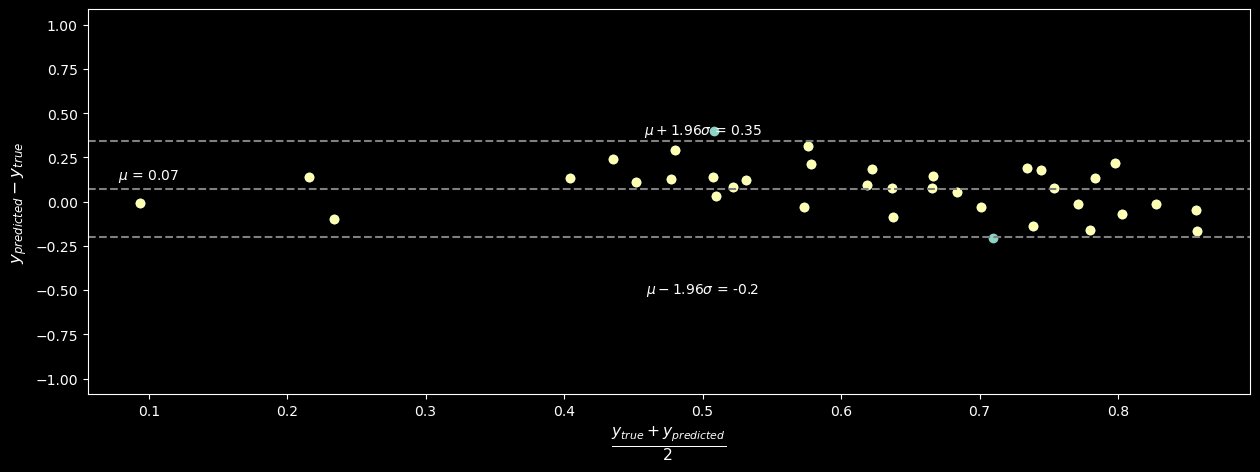

In [19]:
d,din = bland_altman_plot(results_ls_aug,per_change)


../util.py:1199: RuntimeWarning: invalid value encountered in sqrt
  tr = r*np.sqrt(n-2)/(np.sqrt(1-r**2))
../util.py:1199: RuntimeWarning: invalid value encountered in sqrt
  tr = r*np.sqrt(n-2)/(np.sqrt(1-r**2))


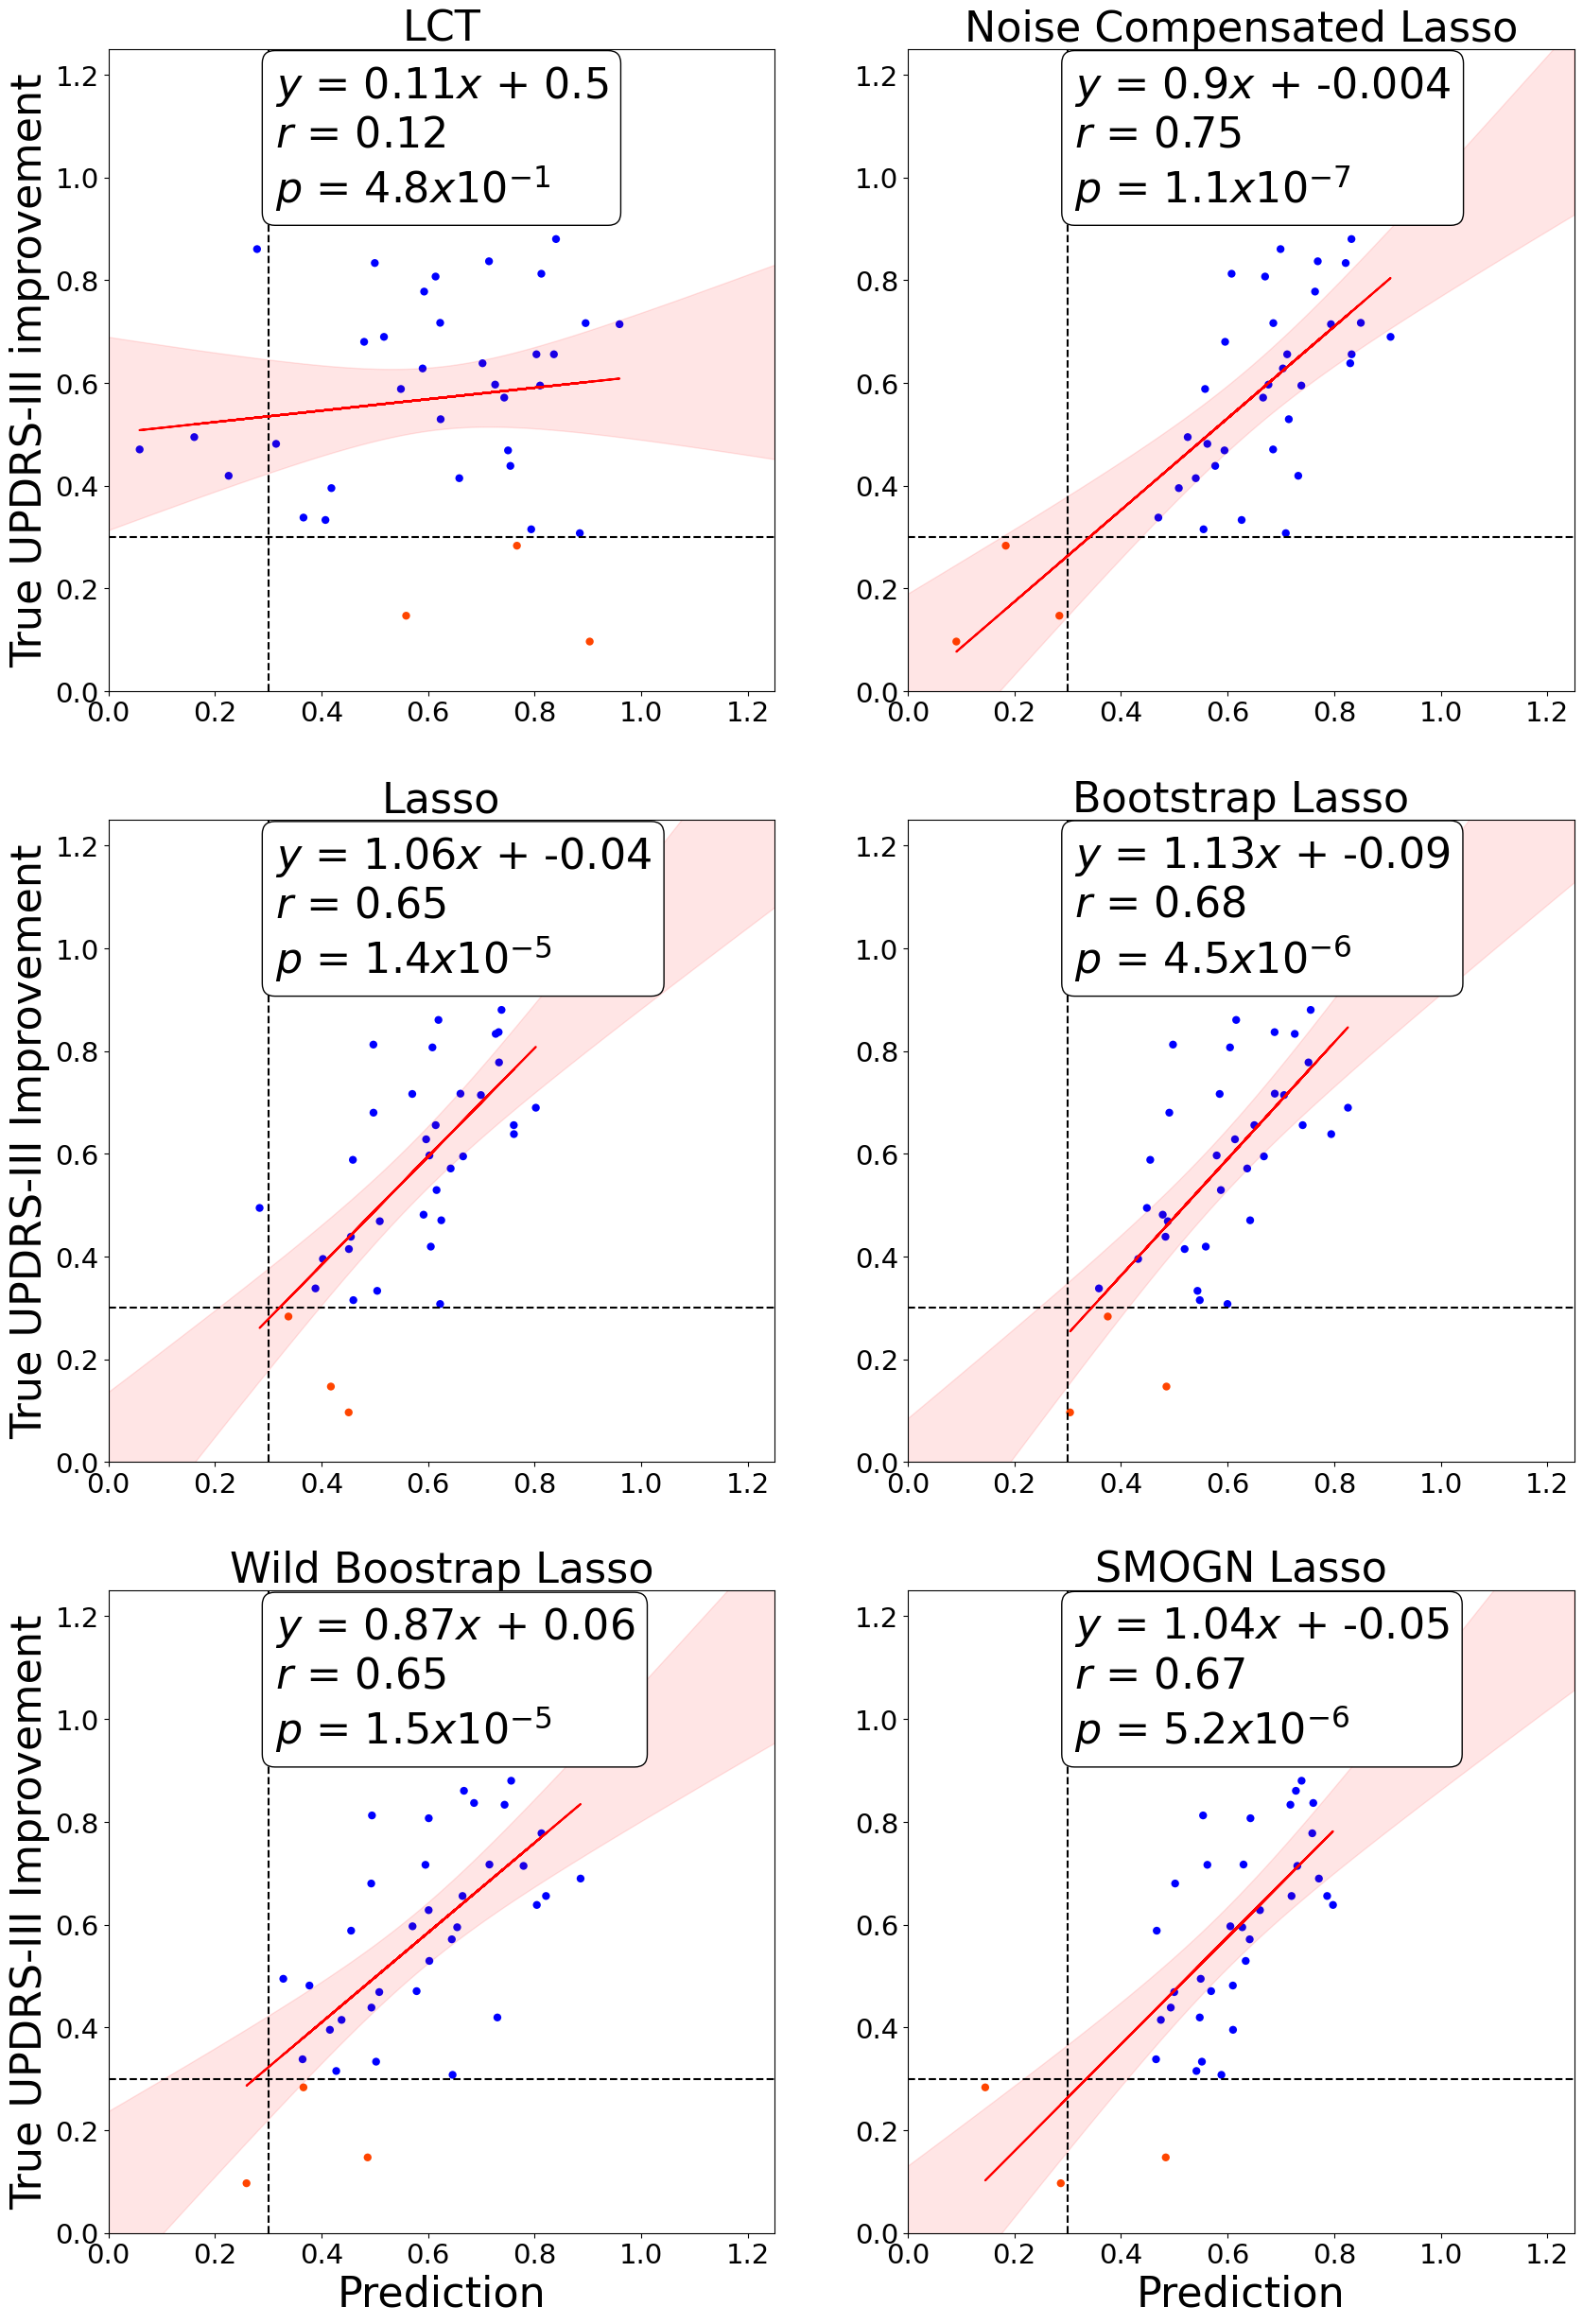

In [178]:
ylim = 1.25
fs = 32
ofx = 0.25
ofy = 0.745
pre_imp = np.repeat((np.asarray(pre_updrs_iii_off,dtype=float)-np.asarray(pre_updrs_iii_on,dtype=float))/np.asarray(pre_updrs_iii_off,dtype=float),r)
per_change = np.repeat(per_change,r)
plt.rcParams['figure.figsize'] = [20, 30]
fig,ax = plt.subplots(3,2,sharex=True,sharey=True)
col = np.where(per_change <= 0.3,'orangered','blue')
ax[0,0].scatter(pre_imp,per_change, c=col,linewidth=0)
lr = stats.linregress(pre_imp,per_change)
y_model = pre_imp*lr.slope+lr.intercept
ax[0,0].plot(pre_imp,y_model,color='r')
pl = r'$'+util.latex_sci(lr.pvalue,1)+'$'
ax[0,0].text(ofx,ofy,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+pl,
                    ha='left', va='bottom', transform=ax[0,0].transAxes,fontsize=fs,
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))  
ci,pi,x_line,y_line = util.confidence_interval(pre_imp,per_change,ylim)
ax[0,0].fill_between(x_line,y_line+ci,y_line-ci,color = 'r',label = '95% confidence interval',alpha=0.1)
ax[0,0].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[0,0].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[0,0].set_title('LCT',fontsize=fs)
ax[0,0].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[0,0].set_ylabel('True UPDRS-III improvement',fontsize=fs)
ax[0,0].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)

ax[1,1].scatter(results_ls,per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(results_ls),per_change)
y_model = results_ls*lr.slope+lr.intercept
ax[1,1].plot(results_ls,y_model,color='r')
pl = r'$'+util.latex_sci(lr.pvalue,1)+'$'
ax[1,1].text(ofx,ofy,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+pl,
                    ha='left', va='bottom', transform=ax[1,1].transAxes,fontsize=fs,
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round')) 
ci,pi,x_line,y_line = util.confidence_interval(results_ls,per_change,ylim)
ax[1,1].fill_between(x_line,y_line+ci,y_line-ci,color = 'r',label = '95% confidence interval',alpha=0.1)
ax[1,1].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[1,1].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[1,1].set_title('Bootstrap Lasso',fontsize=fs)
ax[1,1].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[1,1].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)

ax[2,1].scatter(results_ls_smogn,per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(results_ls_smogn),per_change)
y_model = results_ls_smogn*lr.slope+lr.intercept
ax[2,1].plot(results_ls_smogn,y_model,color='r')
pl = r'$'+util.latex_sci(lr.pvalue,1)+'$'
ax[2,1].text(ofx,ofy,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+pl,
                    ha='left', va='bottom', transform=ax[2,1].transAxes,fontsize=fs,
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round')) 
ci,pi,x_line,y_line = util.confidence_interval(results_ls_smogn,per_change,ylim)
ax[2,1].fill_between(x_line,y_line+ci,y_line-ci,color = 'r',label = '95% confidence interval',alpha=0.1)
ax[2,1].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[2,1].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[2,1].set_xlabel('Prediction',fontsize=fs)
ax[2,1].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[2,1].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[2,1].set_title('SMOGN Lasso',fontsize=fs)

ax[2,0].scatter(results_ls_wbs,per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(results_ls_wbs),per_change)
y_model = results_ls_wbs*lr.slope+lr.intercept
ax[2,0].plot(results_ls_wbs,y_model,color='r')
pl = r'$'+util.latex_sci(lr.pvalue,1)+'$'
ax[2,0].text(ofx,ofy,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+pl,
                    ha='left', va='bottom', transform=ax[2,0].transAxes,fontsize=fs,
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round')) 
ci,pi,x_line,y_line = util.confidence_interval(results_ls_wbs,per_change,ylim)
ax[2,0].fill_between(x_line,y_line+ci,y_line-ci,color = 'r',label = '95% confidence interval',alpha=0.1)
ax[2,0].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[2,0].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[2,0].set_xlabel('Prediction',fontsize=fs)
ax[2,0].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[2,0].set_ylabel('True UPDRS-III Improvement',fontsize=fs)
ax[2,0].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[2,0].set_title('Wild Boostrap Lasso',fontsize=fs)

ax[0,1].scatter(results_ls_aug,per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(results_ls_aug),per_change)
y_model = results_ls_aug*lr.slope+lr.intercept
ax[0,1].plot(results_ls_aug,y_model,color='r')
pl = r'$'+util.latex_sci(lr.pvalue,1)+'$'
ax[0,1].text(ofx,ofy,'$y$ = '+str(np.round(lr.slope,1))+'$x$ + '+str(np.round(lr.intercept,3))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+pl,
                    ha='left', va='bottom', transform=ax[0,1].transAxes,fontsize=fs,
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round')) 
ci,pi,x_line,y_line = util.confidence_interval(results_ls_aug,per_change,ylim)
ax[0,1].fill_between(x_line,y_line+ci,y_line-ci,color = 'r',label = '95% confidence interval',alpha=0.1)
ax[0,1].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[0,1].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[0,1].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[0,1].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[0,1].set_title('Noise Compensated Lasso',fontsize=fs)
plt.ylim([0,ylim])
plt.xlim([0,ylim])

ax[1,0].scatter(results_lsw,per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(results_lsw),per_change)
y_model = results_lsw*lr.slope+lr.intercept
ax[1,0].plot(results_lsw,y_model,color='r')
pl = r'$'+util.latex_sci(lr.pvalue,1)+'$'
ax[1,0].text(ofx,ofy,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+pl,
                    ha='left', va='bottom', transform=ax[1,0].transAxes,fontsize=fs,
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round')) 
ci,pi,x_line,y_line = util.confidence_interval(results_lsw,per_change,ylim)
ax[1,0].fill_between(x_line,y_line+ci,y_line-ci,color = 'r',label = '95% confidence interval',alpha=0.1)
ax[1,0].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[1,0].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[1,0].set_title('Lasso',fontsize=fs)
ax[1,0].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[1,0].set_ylabel('True UPDRS-III Improvement',fontsize=fs)
ax[1,0].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)


plt.savefig('plots_auto.png')
plt.style.use('default')

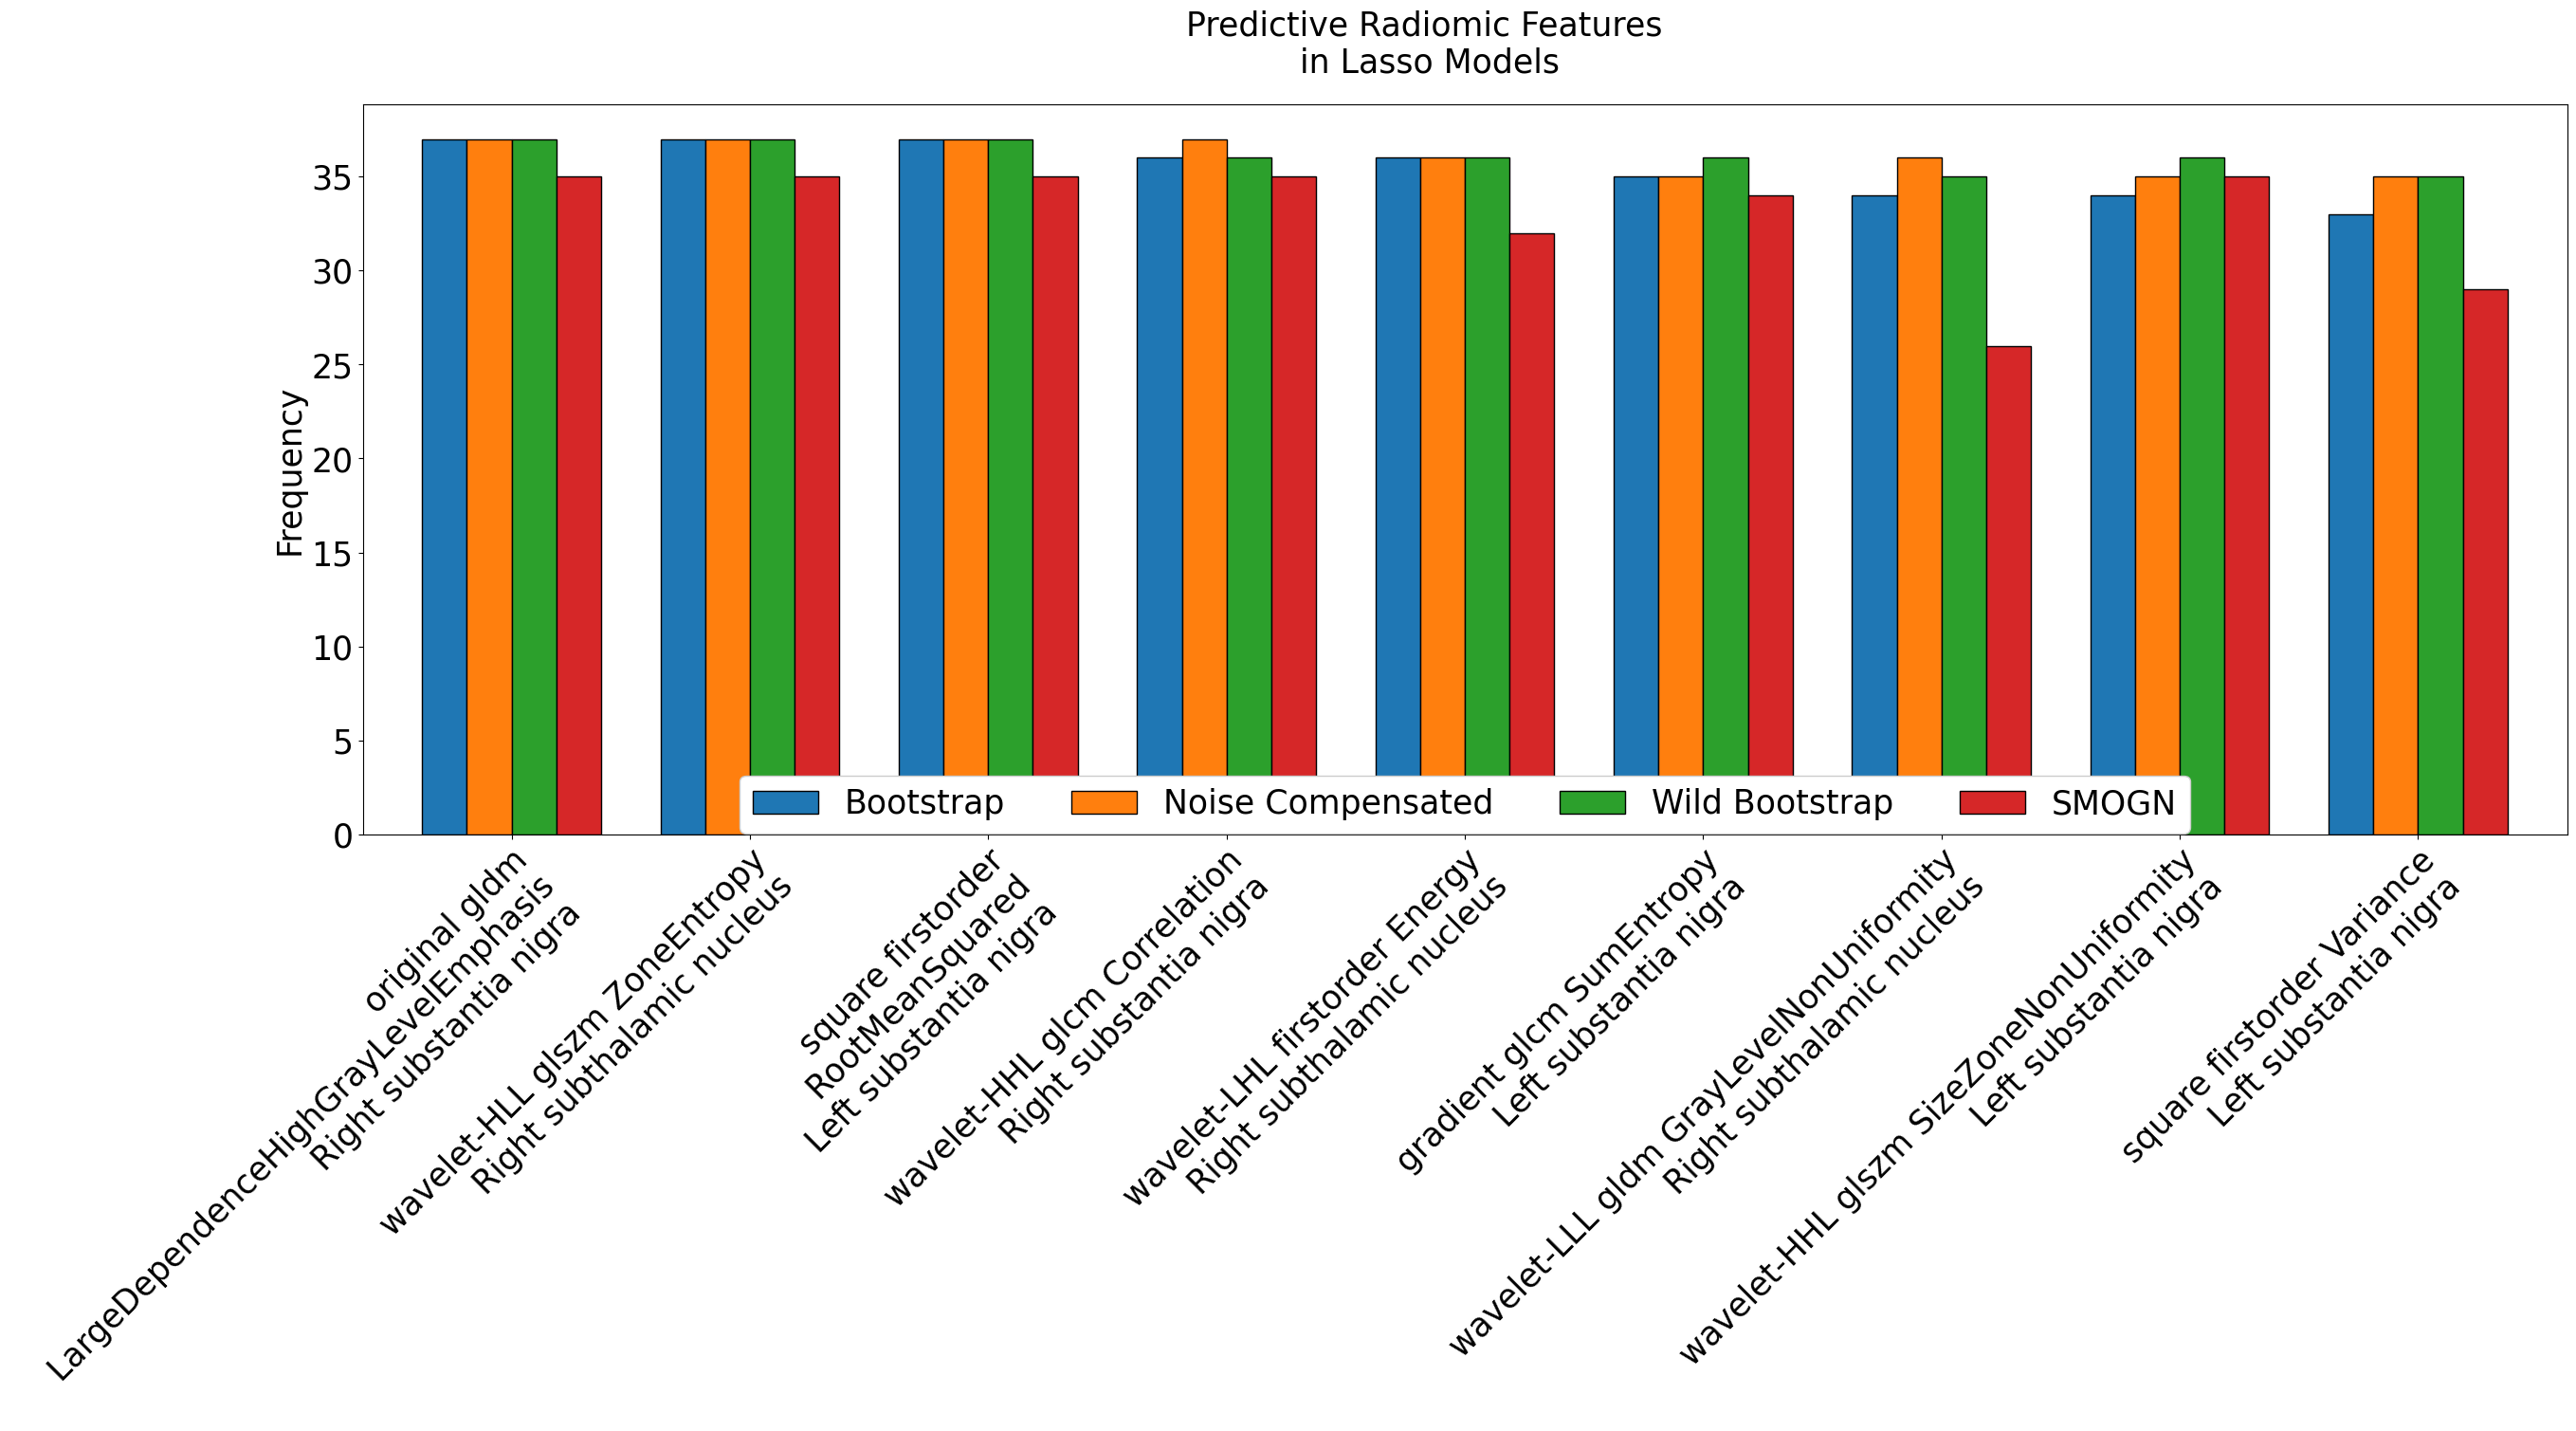

In [179]:
from collections import Counter

E_nz_nc = np.load('beta_nz_nc_cvs.npy',allow_pickle=True)
plt.rcParams["figure.figsize"] = (30,10)
fig, axes = plt.subplots(1,1,sharey=True)

R = [item for sublist in K_nz_nc for item in sublist]
letter_counts = Counter(R)
lc = {x: count for x, count in letter_counts.items() if count >= 35}
df_lc = pd.DataFrame.from_dict(lc, orient='index')
df_lc.sort_values(0, ascending=False, inplace=True)

R = [item for sublist in K_nz_vl for item in sublist]
letter_counts = Counter(R)
lcv = {x: count for x, count in letter_counts.items() if x in lc.keys()}
df_lcv = pd.DataFrame.from_dict(lcv, orient='index')
df_lcv.sort_values(0, ascending=False, inplace=True)

R = [item for sublist in K_nz_wbs for item in sublist]
letter_counts = Counter(R)
lwbs = {x: count for x, count in letter_counts.items() if x in lc.keys()}
df_lwbs = pd.DataFrame.from_dict(lwbs, orient='index')
df_lwbs.sort_values(0, ascending=False, inplace=True)

R = [item for sublist in K_nz_smogn for item in sublist]
letter_counts = Counter(R)
lsm = {x: count for x, count in letter_counts.items() if x in lc.keys()}
df_lsm = pd.DataFrame.from_dict(lsm, orient='index')
df_lsm.sort_values(0, ascending=False, inplace=True) 

df = pd.concat([df_lcv, df_lc, df_lwbs, df_lsm],axis=1)
df.columns = ["Bootstrap","Noise Compensated", "Wild Bootstrap", "SMOGN"]
df.index = df.index.str.replace('_', ' ')
df.index = df.index.str.replace(' L', '\n L')
df.index = df.index.str.replace(' R', '\n R')
df.plot(ax=axes, kind='bar', legend=True, fontsize=fs//1.25, width=0.75, edgecolor='black')

plt.legend(loc='lower center', framealpha=1,fontsize=fs//1.25, ncol=4, bbox_to_anchor=(0.5, -0.02175))
plt.xticks(rotation=45,ha='right',wrap=True)
plt.suptitle('Predictive Radiomic Features \nin Lasso Models',fontsize=fs//1.25)
plt.ylabel('Frequency',fontsize=fs//1.25)

plt.style.use('default')
plt.savefig('feats_auto.png')

In [180]:
beta = np.zeros((len(per_change),len(lc.keys())))
X_r =  np.zeros((3,len(lc.keys())))
X_nr =  np.zeros((3,len(lc.keys())))
for j in np.arange(0,len(K_nz_nc)):
    c = 0
    for k in np.arange(0,len(K_nz_nc[j])):
        if K_nz_nc[j][k] in lc.keys():
            beta[j,c] = E_nz_nc[j][k]
    
            X_r[:,c] = (X_all_c.reshape(len(per_change),-1)[per_change>0.85,np.where(K_all_c == K_nz_nc[j][k])]).astype(float)
            X_nr[:,c] = (X_all_c.reshape(len(per_change),-1)[per_change<0.3,np.where(K_all_c == K_nz_nc[j][k])]).astype(float)

            c = c+1

for i in np.arange(len(lc.keys())):
    res = stats.wilcoxon(X_r[:,i].ravel(),X_nr[:,i].ravel())
    if res.pvalue <= 0.05:
        print(res.statistic, res.pvalue)     
        print('Responder median:',np.median(X_r[:,i]/np.amax(X_r[:,i])),'and non-responder median',np.median(X_nr[:,i]/np.amax(X_nr[:,i])))  

beta_r = (beta[per_change>0.85,:])
beta_nr = (beta[per_change<0.3,:])
res = stats.wilcoxon(beta_r.ravel(),beta_nr.ravel())

In [181]:
from sklearn.metrics import precision_recall_curve, recall_score, accuracy_score, precision_score

/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


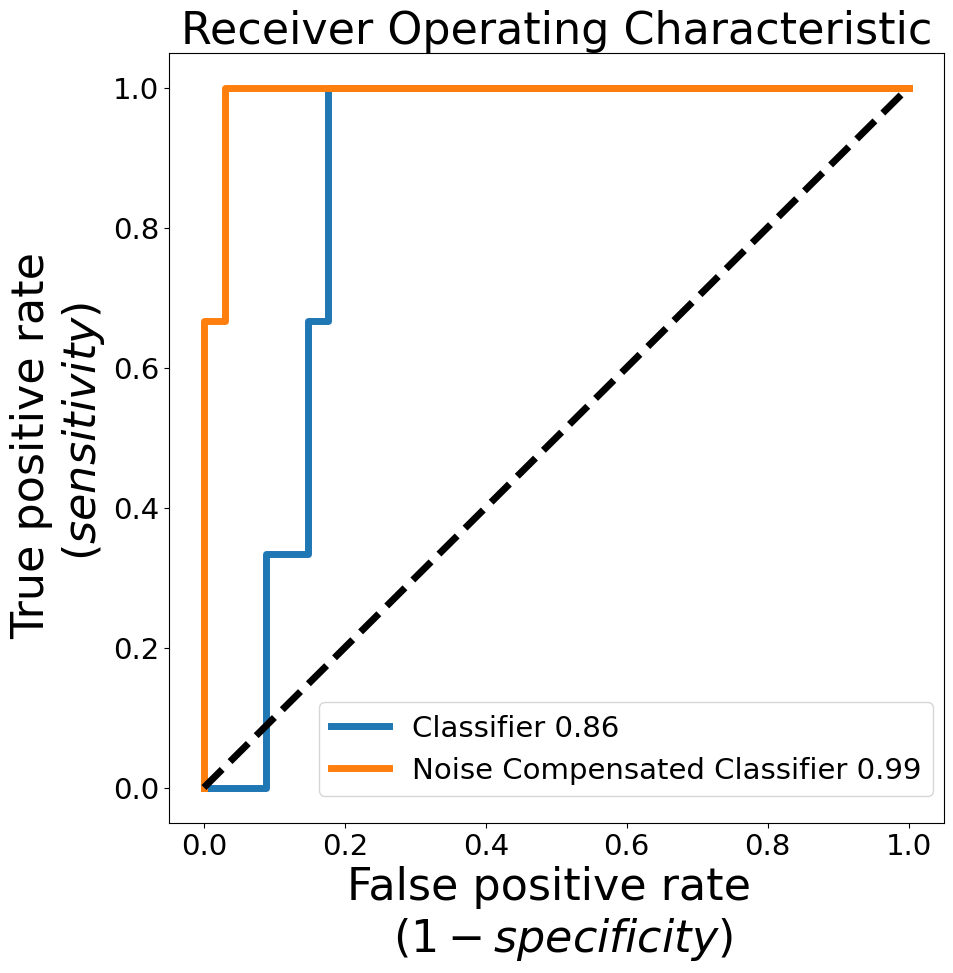

In [182]:
plt.rcParams["figure.figsize"] = (10,10)
fig,ax = plt.subplots(1,1,sharex=True,sharey=True)
t = 0.3
y_bin = per_change<t

y_predicted_ls = results_ls < 0.3
y_predicted_ls_aug = results_ls_aug < 0.3
y_predicted_lct = pre_imp < 0.3
y_predicted_aug = 1-results_lgrp_aug
y_predicted_lr = 1-results_lgrp
y_predicted_smogn = results_ls_smogn < 0.3
y_predicted_wbs = results_ls_wbs < 0.3

estimators = np.vstack((lct_change < 0.3,results_lgr,results_lgr_aug,results_ls < 0.3,results_ls_aug < 0.3,results_ls_smogn < 0.3,results_ls_wbs < 0.3))


fprlsa, tprlsa, _ = roc_curve(y_bin,  y_predicted_ls_aug)
fprls, tprls, _ = roc_curve(y_bin,  y_predicted_ls)
fprl, tprl, _ = roc_curve(y_bin,  y_predicted_lct)
fpra, tpra, ts_aug = roc_curve(y_bin, y_predicted_aug)
fprlr, tprlr, ts = roc_curve(y_bin, y_predicted_lr)
pra,rca,ta = precision_recall_curve(y_bin,y_predicted_aug)
prlr,rclr,tlr = precision_recall_curve(y_bin,y_predicted_lr)

scores = np.zeros((7,4))

for j in np.arange(estimators.shape[0]):
    spf = recall_score(y_bin,estimators[j,:],pos_label=0)
    scores[j,0] = spf
    sns = recall_score(y_bin,estimators[j,:])
    scores[j,1] = sns
    acc = accuracy_score(y_bin,estimators[j,:])
    scores[j,2] = acc
    prec = precision_score(y_bin,estimators[j,:])
    scores[j,3] = prec

fprlss, tprlss, _ = roc_curve(y_bin, y_predicted_smogn)
fprlwb, tprlwb, _ = roc_curve(y_bin, y_predicted_wbs)
roc_auc_lr = auc(fprlr, tprlr)
roc_auc_lr_aug = auc(fpra, tpra)
roc_auc_ls = auc(fprls, tprls)
roc_auc_lct = auc(fprl, tprl)
roc_auc_ls_aug = auc(fprlsa, tprlsa)
roc_auc_ls_smogn = auc(fprlss, tprlss)
roc_auc_ls_wbs = auc(fprlwb, tprlwb)

ax.plot(fprlr, tprlr, label = 'Classifier %0.2f' % roc_auc_lr, linewidth=5)
ax.plot(fpra, tpra, label = 'Noise Compensated Classifier %0.2f' % roc_auc_lr_aug, linewidth=5)

ax.plot(np.linspace(0,1,len(fpra)),np.linspace(0,1,len(fpra)),linewidth=5,color='black',linestyle='dashed')
ax.set_title('Receiver Operating Characteristic',fontsize=fs)
ax.set_xlabel('False positive rate \n $(1-specificity$)',fontsize=fs)
ax.set_ylabel('True positive rate \n $(sensitivity$)',fontsize=fs)
ax.xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax.yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax.legend(bbox_to_anchor=(0.175,0.175),fontsize=fs//1.5)

plt.style.use('default')
plt.show()

In [183]:
def rec(res,pc):
        y_true = pc
        y_pred = res
        epsilon_0 = 0.0
        epsilon_max = 1.0
        d_epsilon = 0.05
        y = []
        x = np.arange(epsilon_0,epsilon_max,d_epsilon)
        epsilon = np.abs(y_true-y_pred) 
        for j in np.arange(len(x)):
            c = 0
            for k in np.arange(len(epsilon)):
                if epsilon[k] < x[j]:
                    c = c+1
            y.append(c/len(y_true))
        auc_rec = scipy.integrate.simps(y,x)/epsilon_max
        return x, np.array(y), auc_rec



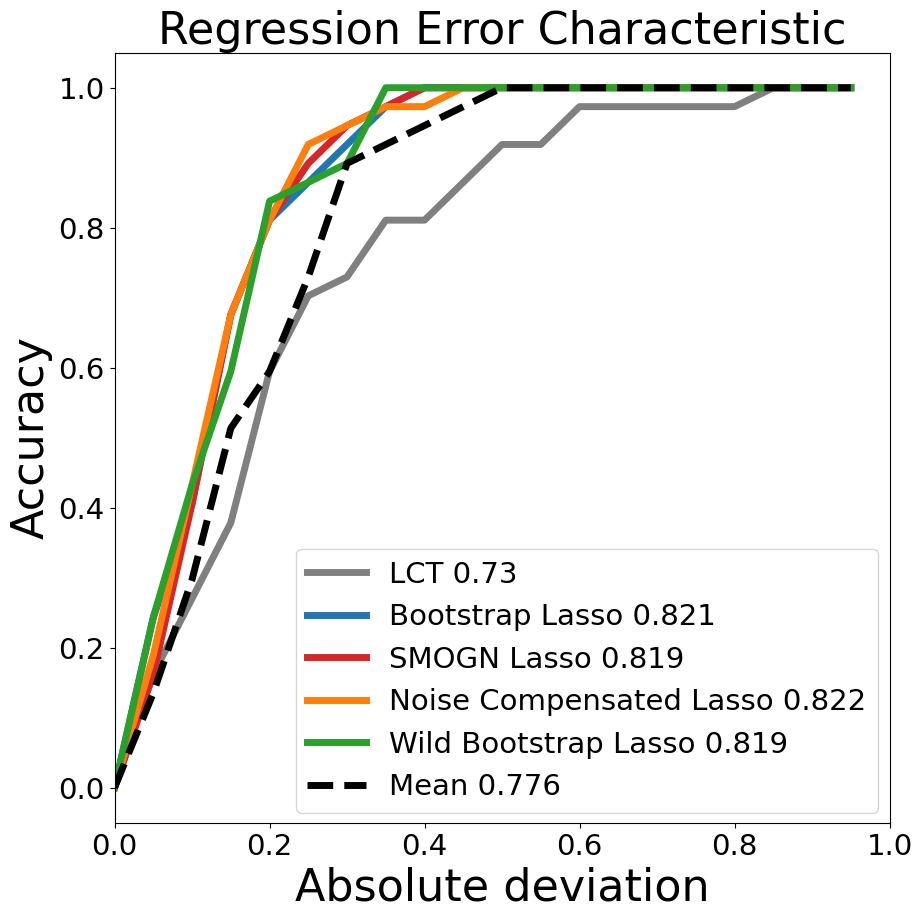

In [184]:
plt.rcParams["figure.figsize"] = (10,10)
fig,ax = plt.subplots(1,1,sharex=True,sharey=True)
x_lct,y_lct,eta = rec(pre_imp,per_change)
plt.plot(x_lct,y_lct,linewidth=5,label='LCT %0.2f' % eta, color='gray')
# x_ls,y_ls,a,eta = rec(results_ls,per_change)
# plt.plot(x_ls,y_ls,label='Lasso %0.2f' % eta)
x_ls,y_ls,eta = rec(results_lsw,per_change)
plt.plot(x_ls,y_ls,linewidth=5,label='Bootstrap Lasso %0.3f' % eta, color='tab:blue')
x_smogn,y_smogn,eta = rec(results_ls_smogn,per_change)
plt.plot(x_smogn,y_smogn,linewidth=5,label='SMOGN Lasso %0.3f' % eta, color='tab:red')
x_lsa,y_lsa,eta = rec(results_ls_aug,per_change)
plt.plot(x_lsa,y_lsa,linewidth=5,label='Noise Compensated Lasso %0.3f' % eta, color='tab:orange')
x_wbs,y_wbs,eta = rec(results_ls_wbs,per_change)
plt.plot(x_wbs,y_wbs,linewidth=5,label='Wild Bootstrap Lasso %0.3f' % eta, color="tab:green")
x_n,y_n,eta = rec(np.mean(per_change)*np.ones_like(per_change),per_change)
plt.plot(x_n,y_n,linestyle='dashed',color='k',linewidth=5,label='Mean %0.3f' % eta)
plt.xlabel('Absolute deviation',fontsize=fs)
plt.ylabel('Accuracy',fontsize=fs)
plt.xlim([0,1])
plt.title('Regression Error Characteristic',fontsize=fs)
ax.xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax.yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax.legend(bbox_to_anchor=(0.215,0.375),fontsize=fs//1.5)


.

(-3.0, 3.0)

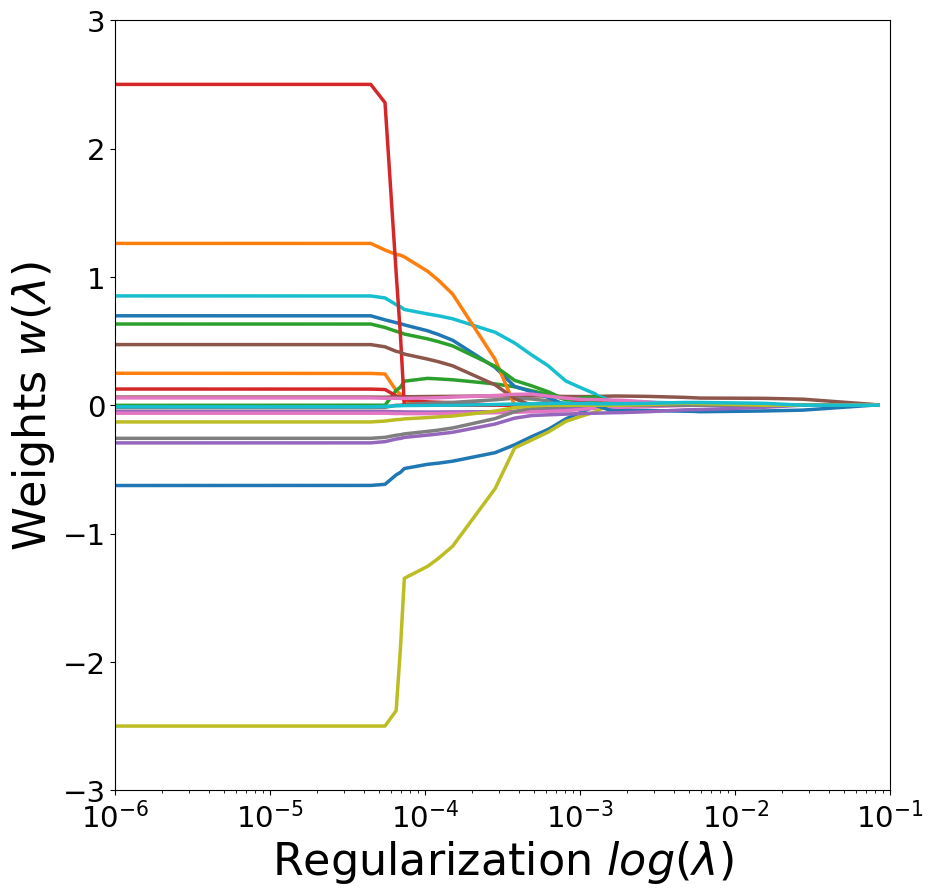

In [185]:
alphas_lasso, _, coefs_lasso = slm.lars_path(X0_ss0[:,0:20], y_train, method="lasso", verbose=True)
from itertools import cycle
plt.rcParams["figure.figsize"] = (10,10)
plt.figure(1)
coefs_lasso[coefs_lasso > 2.5] = 2.5
coefs_lasso[coefs_lasso < -2.5] = -2.5
for coef_l in zip(coefs_lasso):
    l1 = plt.semilogx(alphas_lasso, np.squeeze(coef_l),linewidth=2.5)
plt.xticks(fontsize=fs//1.5)
plt.yticks(fontsize=fs//1.5)

plt.xlabel(r"Regularization $log(\lambda)$",fontsize=fs)
plt.ylabel(r"Weights $w(\lambda)$",fontsize=fs)
plt.axis("tight")
plt.style.use('default')
plt.xlim([1e-6,0.1])
plt.ylim([-3,3])